# Import Libraries

In [3]:
import time
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm
import warnings
import math
from pathlib import Path 

# Display Setting

In [4]:
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth',999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows",999)

# Load Function

In [5]:
import Functions as impFunctions

# Load Data

In [89]:
countries = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/countries.csv")
currency_details = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/currency_details.csv")
fraudsters = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/fraudsters.csv")
transactions = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/transactions.csv")
users = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/users.csv")

In [5]:
print("countries shape        ===> ",countries.shape)
print("currency_details shape ===> ",currency_details.shape)
print("fraudsters shape       ===> ",fraudsters.shape)
print("transactions shape     ===> ",transactions.shape)
print("users shape            ===> ",users.shape)

countries shape        ===>  (226, 5)
currency_details shape ===>  (184, 3)
fraudsters shape       ===>  (298, 1)
transactions shape     ===>  (688651, 12)
users shape            ===>  (9944, 11)


# Validating My SQL results Part-I

In [6]:
transactions[~transactions.USER_ID.isin(fraudsters.USER_ID.tolist())].shape

(674737, 12)

In [7]:
len(transactions.USER_ID.unique().tolist())

8021

In [8]:
len(transactions[~transactions.USER_ID.isin(fraudsters.USER_ID.tolist())].USER_ID.unique().tolist())

7724

In [10]:
len(fraudsters.USER_ID.unique().tolist())

298

In [11]:
len(users.ID.unique().tolist())

9944

In [13]:
users[~users.ID.isin(fraudsters.USER_ID.tolist())].shape

(9646, 11)

In [14]:
transactions[transactions.USER_ID.isin(users[~users.ID.isin(fraudsters.USER_ID.tolist())].ID.tolist())].shape

(624828, 12)

In [15]:
transactions[~transactions.USER_ID.isin(fraudsters.USER_ID.tolist())].groupby(
    'USER_ID', as_index=False).agg({"AMOUNT_USD": ["mean","median","std"]}).head()

USER_ID   AMOUNT_USD                      
                                                mean  median           std
0  000e88bb-d302-4fdc-b757-2b1a2c33e7d6  2412.750000   607.5   3092.509003
1  001032e0-8071-4baf-95b9-e50214665c2e  6231.638889  1862.5   8757.285904
2  00131af8-66f0-4526-8b5f-dc2fdb26c7d7  2082.000000  1112.0   1714.771997
3  001926be-3245-43fa-86dd-b40ee160b6f9  7196.748031  2729.5  12167.228630
4  001cc034-5730-47c6-a70c-25f42249c9ee  2087.500000  2772.5   1376.362476

In [16]:
transactions[~transactions.USER_ID.isin(fraudsters.USER_ID.tolist())].groupby(
    'USER_ID', as_index=False).agg({"AMOUNT_USD": ["mean","std","median"]}).shape

(7724, 4)

Final SQL optimized Query

# Data Overview

## Transactions

- all transactions conducted by users
- **amount** and **amount_usd** is denominated in integers at the lowest unit. e.g. 5000 USD => 50 USD (because the lowest unit in USD is a cent, w/ 100 cents = 1 dollar)
- **entry_method** is only relevant for card transactions (CARD_PAYMENT, ATM); you may ignore it for other transactions. The values are:
    misc - unknown
    chip - chip on card
    mags - magstripe on card
    manu - manual entry of card details
    cont - contactless/tap 
    mcon - special case of magstripe & contactless
- **source** is associated with an external party we use for handling this type of transaction. (e.g. all {CARD_PAYMENT, ATM} use GAIA)
- **type**
    P2P - sending money internally through the Revolut platform (e.g. send money without bank account)
    BANK_TRANSFER - sending money externally to a bank account
    ATM - withdrawing money from an ATM. Revolut does not support ATM deposits at the moment

- **state** 
    COMPLETED - the transaction was completed and the user's balance was changed
    DECLINED/FAILED - the transaction was declined for some reason, usually pertains to insufficient balance 
    REVERTED - the associated transaction was completed first but was then rolled back later in time potentially due to customer reaching out to Revolut


In [18]:
transactions.columns.tolist()

['CURRENCY',
 'AMOUNT',
 'STATE',
 'CREATED_DATE',
 'MERCHANT_CATEGORY',
 'MERCHANT_COUNTRY',
 'ENTRY_METHOD',
 'USER_ID',
 'TYPE',
 'SOURCE',
 'ID',
 'AMOUNT_USD']

In [19]:
transactions.head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD
0,GBP,175,COMPLETED,2017-12-20 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,b3332e6f-7865-4d6e-b6a5-370bc75568d8,220
1,EUR,2593,COMPLETED,2017-12-20 12:38:47.232,bar,AUS,cont,ed773c34-2b83-4f70-a691-6a7aa1cb9f11,CARD_PAYMENT,GAIA,853d9ff8-a007-40ef-91a2-7d81e29a309a,2885
2,EUR,1077,COMPLETED,2017-12-20 12:34:39.668,NaN,CZE,cont,eb349cc1-e986-4bf4-bb75-72280a7b8680,CARD_PAYMENT,GAIA,04de8238-7828-4e46-91f1-050a9aa7a9df,1198
3,GBP,198,COMPLETED,2017-12-20 12:45:50.555,supermarket,GBR,cont,dc78fbc4-c936-45d3-a813-e2477ac6d74b,CARD_PAYMENT,GAIA,2b790b9b-c312-4098-a4b3-4830fc8cda53,249
4,EUR,990,COMPLETED,2017-12-20 12:45:32.722,NaN,FRA,cont,32958a5c-2532-42f7-94f9-127f2a812a55,CARD_PAYMENT,GAIA,6469fc3a-e535-41e9-91b9-acb46d1cc65d,1101


In [20]:
transactions.isnull().sum()

CURRENCY                  0
AMOUNT                    0
STATE                     0
CREATED_DATE              0
MERCHANT_CATEGORY    465586
MERCHANT_COUNTRY     205596
ENTRY_METHOD              0
USER_ID                   0
TYPE                      0
SOURCE                    0
ID                        0
AMOUNT_USD                0
dtype: int64

I think these missing values corresponds for non-Merchant related transaction.

In [21]:
transactions.dtypes

CURRENCY             object
AMOUNT                int64
STATE                object
CREATED_DATE         object
MERCHANT_CATEGORY    object
MERCHANT_COUNTRY     object
ENTRY_METHOD         object
USER_ID              object
TYPE                 object
SOURCE               object
ID                   object
AMOUNT_USD            int64
dtype: object

We will need to convert CREATED_DATE to Datetime type

## Users

- a table of user data
- **kyc** column indicates the status of the user's identity verification process
- **terms_version** column indiciates the user's current version of the Revolut app
- **state**
    LOCKED - the user's account is locked and they cannot perform any transactions. If there are transactions for this user, they occurred before the user was LOCKED.

In [22]:
users.columns.tolist()

['ID',
 'HAS_EMAIL',
 'PHONE_COUNTRY',
 'IS_FRAUDSTER',
 'TERMS_VERSION',
 'CREATED_DATE',
 'STATE',
 'COUNTRY',
 'BIRTH_YEAR',
 'KYC',
 'FAILED_SIGN_IN_ATTEMPTS']

In [95]:
users.sample(5)

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
362,3192de35-8e6e-445a-b6ff-b3d9a3686bf7,1,CY,False,2018-03-20,2018-02-09 15:31:57.594000,ACTIVE,CY,1982,NONE,0
7237,23ca430a-f503-4b0d-8798-0d6b15caccd4,1,GR,False,NaN,2016-07-11 10:11:22.498000,ACTIVE,GR,1987,NONE,0
8426,d8e05abe-9845-4f7c-9113-871818193d3a,1,GB||JE||IM||GG,True,2018-03-20,2017-11-25 23:42:12.148000,LOCKED,GB,1992,PASSED,0
6748,a57f662c-c60a-49bd-8c54-bd555c0a5ffa,1,IE,False,2018-09-20,2017-09-25 21:19:58.962000,ACTIVE,IE,1990,PASSED,0
3768,369655f7-3de5-47b8-8126-b01e88a69bbc,1,GB||JE||IM||GG,False,2018-05-25,2017-05-02 17:34:30.091000,ACTIVE,GB,1994,PASSED,0


In [92]:
users.isnull().sum()

ID                            0
HAS_EMAIL                     0
PHONE_COUNTRY                 0
IS_FRAUDSTER                  0
TERMS_VERSION              1527
CREATED_DATE                  0
STATE                         0
COUNTRY                       0
BIRTH_YEAR                    0
KYC                           0
FAILED_SIGN_IN_ATTEMPTS       0
dtype: int64

Term version is null may signify either the user has not upgraded the application or is using some proxy to hope the information 

In [25]:
users.TERMS_VERSION.value_counts(dropna=False)

2018-05-25    3393
2018-09-20    2109
2018-03-20    2048
NaN           1527
2018-01-13     440
2018-01-01     232
2017-01-16     121
2017-02-02      74
Name: TERMS_VERSION, dtype: int64

In [27]:
pd.crosstab(users['TERMS_VERSION'].fillna('1970-01-01'),users['IS_FRAUDSTER'],dropna=False)

IS_FRAUDSTER,False,True
TERMS_VERSION,,
1970-01-01,1460,67
2017-01-16,121,0
2017-02-02,66,8
2018-01-01,220,12
2018-01-13,434,6
2018-03-20,1934,114
2018-05-25,3302,91
2018-09-20,2109,0


Data Type 

In [29]:
users.dtypes

ID                         object
HAS_EMAIL                   int64
PHONE_COUNTRY              object
IS_FRAUDSTER                 bool
TERMS_VERSION              object
CREATED_DATE               object
STATE                      object
COUNTRY                    object
BIRTH_YEAR                  int64
KYC                        object
FAILED_SIGN_IN_ATTEMPTS     int64
dtype: object

CREATED_DATE AND TERMS_VERSION data type will be changed to date-time

## Countries

- a table with all alpha-numeric representations of countries. You may need to use this to standardise country codes to one format

In [30]:
countries.columns.tolist()

['CODE', 'NAME', 'CODE3', 'NUMCODE', 'PHONECODE']

In [31]:
countries.head()

,CODE,NAME,CODE3,NUMCODE,PHONECODE
0,AF,Afghanistan,AFG,4,93
1,AL,Albania,ALB,8,355
2,DZ,Algeria,DZA,12,213
3,AS,American Samoa,ASM,16,1684
4,AO,Angola,AGO,24,244


In [32]:
countries.isnull().sum()

CODE         1
NAME         0
CODE3        0
NUMCODE      0
PHONECODE    0
dtype: int64

## Fraudsters

- this just holds a list of IDs of users who have been identified as fraudsters for this problem
- there are others in the users table who are fraudsters, the challenge is to identify them as well

In [33]:
fraudsters.columns

Index(['USER_ID'], dtype='object')

In [34]:
fraudsters.head()

,USER_ID
0,5270b0f4-2e4a-4ec9-8648-2135312ac1c4
1,848fc1b1-096c-40f7-b04a-1399c469e421
2,27c76eda-e159-4df3-845a-e13f4e28a8b5
3,a27088ef-9452-403d-9bbb-f7b10180cdda
4,fb23710b-609a-49bf-8a9a-be49c59ce6de


## Currency Details

- a table with iso codes and exponents for currencies
- **exponent** column can be used to convert the integer amounts in the transactions table into cash amounts. (e.g for 5000 GBP, exponent = 2, so we apply: 5000/(10^2) = 50 GBP)


In [35]:
currency_details.columns

Index(['CCY', 'EXPONENT', 'IS_CRYPTO'], dtype='object')

In [36]:
currency_details.head()

,CCY,EXPONENT,IS_CRYPTO
0,AED,2,False
1,AFN,2,False
2,ALL,2,False
3,AMD,2,False
4,ANG,2,False


In [37]:
currency_details.isnull().sum()

CCY          0
EXPONENT     0
IS_CRYPTO    0
dtype: int64

# Data Pre-Processing

## Assumptions 

- we need to predict if the current transaction is fraudulent or not based on the features and then once the transaction is identified as fraudulent we will take further action on the fraudulent user
- So, I will be using 'INNER-JOIN' for users and transactions table
- I will require columns from all the corresponding table for modeling if there are features respectively 

## Joining the DataFrames to create a unified data lake for modeling 

###### transactions & users

In [38]:
resDF = pd.merge(transactions,
                 users,
                 left_on='USER_ID',
                 right_on='ID',
                 how='inner')

In [39]:
resDF[resDF.USER_ID.isin(fraudsters.USER_ID.tolist())].IS_FRAUDSTER.value_counts()

True    13914
Name: IS_FRAUDSTER, dtype: int64

- it seems users DataFrame already has all the fraudulent users mentioned hence, we need not worry on joining the fraudsters list

In [40]:
del fraudsters

In [41]:
resDF.USER_ID.isin(resDF[resDF.IS_FRAUDSTER==True].ID_x.unique().tolist()).value_counts()

False    638742
Name: USER_ID, dtype: int64

- My hypothesis was that transactions ID column is payee's ID and thus, I though there might me some Fraudulent payee's who have further transfered money basically checking for "Mulling Fraud Scenario" But, that's not the case here

###### resDF (transaction & User) and Countries

In [43]:
resDF_I = pd.merge(resDF,
                   countries,
                   left_on='COUNTRY',
                   right_on='CODE',
                   how='left')

###### resDF_I (transactions & users & Countries) and Currency

In [46]:
resDF_II = pd.merge(resDF_I,
                    currency_details,
                    left_on='CURRENCY',
                    right_on='CCY',
                    how='left')

In [47]:
del resDF, resDF_I

## Final Unified DataFrame

In [48]:
unifiedDF = resDF_II.copy()

In [49]:
del resDF_II,transactions,users,countries,currency_details

In [50]:
unifiedDF.shape

(638742, 31)

- Writing the dataFrame to disk for future references 

In [ ]:
unifiedDF.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/FinalDataLakeForModeling.csv",index=False)

- Reading the dataframe from disk

In [ ]:
unifiedDF = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/FinalDataLakeForModeling.csv")

### Changing the Data-Type for date fields

In [51]:
unifiedDF['CREATED_DATE_x'] = pd.to_datetime(unifiedDF.CREATED_DATE_x)
unifiedDF['CREATED_DATE_y'] = pd.to_datetime(unifiedDF.CREATED_DATE_y)
unifiedDF['TERMS_VERSION']  = pd.to_datetime(unifiedDF.TERMS_VERSION)

In [52]:
unifiedDF.dtypes

CURRENCY                           object
AMOUNT                              int64
STATE_x                            object
CREATED_DATE_x             datetime64[ns]
MERCHANT_CATEGORY                  object
MERCHANT_COUNTRY                   object
ENTRY_METHOD                       object
USER_ID                            object
TYPE                               object
SOURCE                             object
ID_x                               object
AMOUNT_USD                          int64
ID_y                               object
HAS_EMAIL                           int64
PHONE_COUNTRY                      object
IS_FRAUDSTER                         bool
TERMS_VERSION              datetime64[ns]
CREATED_DATE_y             datetime64[ns]
STATE_y                            object
COUNTRY                            object
BIRTH_YEAR                          int64
KYC                                object
FAILED_SIGN_IN_ATTEMPTS             int64
CODE                              

## Null Check

In [53]:
unifiedDF.isnull().sum()/unifiedDF.shape[0]*100

CURRENCY                    0.000000
AMOUNT                      0.000000
STATE_x                     0.000000
CREATED_DATE_x              0.000000
MERCHANT_CATEGORY          67.330002
MERCHANT_COUNTRY           30.016032
ENTRY_METHOD                0.000000
USER_ID                     0.000000
TYPE                        0.000000
SOURCE                      0.000000
ID_x                        0.000000
AMOUNT_USD                  0.000000
ID_y                        0.000000
HAS_EMAIL                   0.000000
PHONE_COUNTRY               0.000000
IS_FRAUDSTER                0.000000
TERMS_VERSION               4.016958
CREATED_DATE_y              0.000000
STATE_y                     0.000000
COUNTRY                     0.000000
BIRTH_YEAR                  0.000000
KYC                         0.000000
FAILED_SIGN_IN_ATTEMPTS     0.000000
CODE                        0.061840
NAME                        0.061840
CODE3                       0.061840
NUMCODE                     0.061840
P

as observed there are 67% , 30% of null records in MERCHANT CATEGORY and COUNTRY 

### Handling Null Values 

#### MERCHANT_CATEGORY 

In [55]:
unifiedDF.MERCHANT_CATEGORY.value_counts(dropna=False)[:20]

NaN                       430065
point_of_interest          35240
supermarket                28924
restaurant                 22690
cafe                       12490
bar                        12433
atm                         9440
store                       8354
convenience_store           6496
grocery_or_supermarket      6361
bank                        5479
lodging                     5266
clothing_store              5179
gas_station                 4533
shopping_mall               3499
airport                     2969
department_store            2869
pharmacy                    2836
meal_takeaway               1939
travel_agency               1707
Name: MERCHANT_CATEGORY, dtype: int64

In [56]:
pd.crosstab(unifiedDF.TYPE,unifiedDF.MERCHANT_CATEGORY.fillna('non-card'),dropna=False)

MERCHANT_CATEGORY,accounting,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,administrative_area_level_4,airport,amusement_park,aquarium,archipelago,art_gallery,atm,bakery,bank,bar,beauty_salon,bicycle_store,book_store,bowling_alley,bus_station,cafe,campground,car_dealer,car_rental,car_repair,car_wash,casino,cemetery,church,city_hall,clothing_store,colloquial_area,convenience_store,courthouse,dentist,department_store,doctor,electrician,electronics_store,embassy,finance,fire_station,florist,food,funeral_home,furniture_store,gas_station,general_contractor,grocery_or_supermarket,gym,hair_care,hardware_store,health,hindu_temple,home_goods_store,hospital,insurance_agency,intersection,jewelry_store,laundry,lawyer,library,light_rail_station,liquor_store,local_government_office,locality,locksmith,lodging,meal_delivery,meal_takeaway,movie_rental,movie_theater,moving_company,museum,natural_feature,neighborhood,night_club,non-card,painter,park,parking,pet_store,pharmacy,physiotherapist,place_of_worship,plumber,point_of_interest,police,political,post_office,premise,real_estate_agency,restaurant,roofing_contractor,route,rv_park,school,shoe_store,shopping_mall,spa,stadium,storage,store,street_address,sublocality_level_1,sublocality_level_2,sublocality_level_3,subpremise,subway_station,supermarket,taxi_stand,train_station,transit_station,travel_agency,university,veterinary_care,zoo
TYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ATM,183,6,16,1,1,649,14,0,0,1,5168,1,4505,314,57,0,0,7,14,100,226,10,17,1,0,12,0,0,2,24,9,477,42,0,2,5,0,0,1,86,0,0,5,0,0,28,8,46,14,0,2,13,0,11,4,19,0,0,0,9,50,3,0,7,83,1,295,1,9,0,5,0,3,18,4,1,27050,0,13,9,0,34,0,0,0,987,2,0,48,7,4,60,3,74,0,4,2,142,4,2,0,42,118,5,0,0,1,79,83,0,10,9,27,22,0,0
BANK_TRANSFER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CARD_PAYMENT,74,41,5,40,4,2320,539,150,3,147,4272,1580,974,12119,178,515,1520,49,551,12390,188,102,416,167,81,196,1,85,60,5155,8,6019,2,28,2867,93,70,733,18,597,10,761,1302,17,608,4505,302,6315,274,94,401,295,5,639,392,70,1,168,86,25,144,87,676,465,319,74,4971,628,1930,13,807,218,691,232,112,1636,211520,7,278,735,90,2802,1,3,9,34253,15,3,214,410,395,22630,5,231,21,169,663,3357,357,110,1289,8312,19,14,23,1,22,511,28841,154,1249,794,1680,860,22,117
P2P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54434,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TOPUP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,122311,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- Will fill the NaN's based in combination of TYPE columns as there are NaN's even for ATM type transaction where MERCHANT_CATEGORY is expected to be present

In [57]:
unifiedDF['MERCHANT_CATEGORY_'] = np.where(
    ((unifiedDF.TYPE == 'ATM') & unifiedDF.MERCHANT_CATEGORY.isnull()), 'atm',
    np.where(((unifiedDF.TYPE == 'BANK_TRANSFER')
              & unifiedDF.MERCHANT_CATEGORY.isnull()), 'bank_transfer',
             np.where(((unifiedDF.TYPE == 'CARD_PAYMENT')
                       & unifiedDF.MERCHANT_CATEGORY.isnull()), 'card_payment',
                      np.where(
                          ((unifiedDF.TYPE == 'P2P')
                           & unifiedDF.MERCHANT_CATEGORY.isnull()), 'p2p',
                          np.where(((unifiedDF.TYPE == 'TOPUP')
                                    & unifiedDF.MERCHANT_CATEGORY.isnull()),
                                   'topup', unifiedDF.MERCHANT_CATEGORY)))))

In [61]:
pd.crosstab(unifiedDF.MERCHANT_CATEGORY_.fillna('non-card'),
            unifiedDF.IS_FRAUDSTER,
            dropna=False).sort_values(1,ascending=False)[:20]

IS_FRAUDSTER,False,True
MERCHANT_CATEGORY_,,
card_payment,207750,3770
topup,118636,3675
atm,34656,1834
bank_transfer,13528,1222
point_of_interest,34395,845
p2p,53998,436
supermarket,28555,369
bank,5275,204
restaurant,22487,203


#### MERCHANT_COUNTRY

- Will replace it with MISS

In [62]:
unifiedDF.MERCHANT_COUNTRY.fillna('_MISS',inplace=True)

#### TERM_VERSION

In [64]:
unifiedDF.TERMS_VERSION.fillna(pd.to_datetime('1970-01-01'),inplace=True)

replacing the missing values with epoch start date such that we can identify it as missing value 

#### CODE || NAME || CODE3 || NUMCODE || PHONECODE

In [66]:
unifiedDF[unifiedDF.CODE.isnull()].head()

,CURRENCY,AMOUNT,STATE_x,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID_x,AMOUNT_USD,ID_y,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE_y,STATE_y,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,CODE,NAME,CODE3,NUMCODE,PHONECODE,CCY,EXPONENT,IS_CRYPTO,MERCHANT_CATEGORY_
164909,GBP,150000,COMPLETED,2017-12-19 21:33:47.430,NaN,_MISS,misc,2f11643c-ced8-4b34-bac8-47304afa4597,TOPUP,HERA,61ac9e29-15f8-41b4-b8c5-c12569a7e036,189102,2f11643c-ced8-4b34-bac8-47304afa4597,1,GB||JE||IM||GG,False,2018-05-25,2016-02-18 11:12:04.558,ACTIVE,GG,1987,PASSED,0,NaN,NaN,NaN,NaN,NaN,GBP,2,False,topup
164910,EUR,169515,COMPLETED,2017-12-19 21:39:19.659,NaN,_MISS,misc,2f11643c-ced8-4b34-bac8-47304afa4597,BANK_TRANSFER,LETO,5a751154-c832-4d1e-9c1f-019b8de665bc,188667,2f11643c-ced8-4b34-bac8-47304afa4597,1,GB||JE||IM||GG,False,2018-05-25,2016-02-18 11:12:04.558,ACTIVE,GG,1987,PASSED,0,NaN,NaN,NaN,NaN,NaN,EUR,2,False,bank_transfer
164911,GBP,100,REVERTED,2018-03-06 10:17:52.699,NaN,_MISS,misc,2f11643c-ced8-4b34-bac8-47304afa4597,TOPUP,HERA,ced98325-36b4-4d3d-81e9-68192db440b0,126,2f11643c-ced8-4b34-bac8-47304afa4597,1,GB||JE||IM||GG,False,2018-05-25,2016-02-18 11:12:04.558,ACTIVE,GG,1987,PASSED,0,NaN,NaN,NaN,NaN,NaN,GBP,2,False,topup
164912,GBP,1000,COMPLETED,2018-03-06 10:18:21.968,NaN,_MISS,misc,2f11643c-ced8-4b34-bac8-47304afa4597,TOPUP,HERA,6b2fffcf-d13f-40ce-bfc3-7bb116e66e3b,1260,2f11643c-ced8-4b34-bac8-47304afa4597,1,GB||JE||IM||GG,False,2018-05-25,2016-02-18 11:12:04.558,ACTIVE,GG,1987,PASSED,0,NaN,NaN,NaN,NaN,NaN,GBP,2,False,topup
164913,GBP,1000,COMPLETED,2018-04-12 20:31:20.602,NaN,_MISS,misc,2f11643c-ced8-4b34-bac8-47304afa4597,BANK_TRANSFER,CRONUS,bc54b85b-1356-42a2-bcba-8064eef6d3c2,1260,2f11643c-ced8-4b34-bac8-47304afa4597,1,GB||JE||IM||GG,False,2018-05-25,2016-02-18 11:12:04.558,ACTIVE,GG,1987,PASSED,0,NaN,NaN,NaN,NaN,NaN,GBP,2,False,bank_transfer


In [65]:
unifiedDF.CODE.isnull().sum()/unifiedDF.shape[0]*100

0.06184030484921925

- It seems that the Country code 'GG' is not present in the countries dataframe and there is no fraudulent transaction thus, I choose to drop these records as they comprise of 0.06% records

In [67]:
unifiedDF = unifiedDF[unifiedDF.CODE.notnull()].copy()

In [68]:
unifiedDF.isnull().sum()

CURRENCY                        0
AMOUNT                          0
STATE_x                         0
CREATED_DATE_x                  0
MERCHANT_CATEGORY          429796
MERCHANT_COUNTRY                0
ENTRY_METHOD                    0
USER_ID                         0
TYPE                            0
SOURCE                          0
ID_x                            0
AMOUNT_USD                      0
ID_y                            0
HAS_EMAIL                       0
PHONE_COUNTRY                   0
IS_FRAUDSTER                    0
TERMS_VERSION                   0
CREATED_DATE_y                  0
STATE_y                         0
COUNTRY                         0
BIRTH_YEAR                      0
KYC                             0
FAILED_SIGN_IN_ATTEMPTS         0
CODE                            0
NAME                            0
CODE3                           0
NUMCODE                         0
PHONECODE                       0
CCY                             0
EXPONENT      

### Duplicate Rows 

In [69]:
unifiedDF[unifiedDF.duplicated()].shape

(0, 32)

- No duplicate rows 

### %-Cardinality 

In [71]:
unifiedDF.apply(lambda x: (len(x.unique().tolist())/x.shape[0])*100)

CURRENCY                     0.004543
AMOUNT                       4.884647
STATE_x                      0.001097
CREATED_DATE_x              99.998277
MERCHANT_CATEGORY            0.018172
MERCHANT_COUNTRY             0.047466
ENTRY_METHOD                 0.000940
USER_ID                      1.211567
TYPE                         0.000783
SOURCE                       0.001723
ID_x                       100.000000
AMOUNT_USD                   4.876031
ID_y                         1.211567
HAS_EMAIL                    0.000313
PHONE_COUNTRY                0.011592
IS_FRAUDSTER                 0.000313
TERMS_VERSION                0.001253
CREATED_DATE_y               1.211567
STATE_y                      0.000313
COUNTRY                      0.006423
BIRTH_YEAR                   0.010496
KYC                          0.000627
FAILED_SIGN_IN_ATTEMPTS      0.000783
CODE                         0.006423
NAME                         0.006423
CODE3                        0.006423
NUMCODE     

### Sort Data w.r.t CREATE_DATE_x(transaction datetime)

In [72]:
unifiedDF = unifiedDF.sort_values('CREATED_DATE_x',ascending=True).copy()

In [77]:
unifiedDF['transaction_Year'] = unifiedDF.CREATED_DATE_x.dt.year.copy()
unifiedDF['transaction_Month'] = unifiedDF.CREATED_DATE_x.dt.month.copy()
unifiedDF['Fraud0rNot'] = unifiedDF.IS_FRAUDSTER.copy()
unifiedDF.drop(columns=['IS_FRAUDSTER'],inplace=True)

#### Data Distribution Over Time 

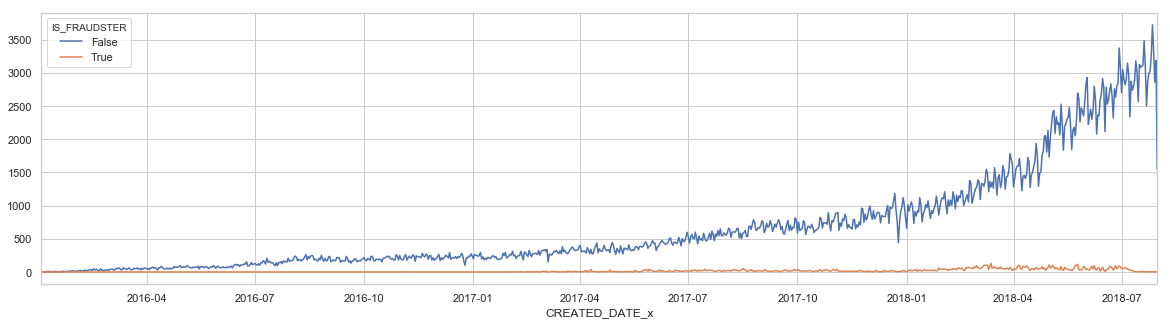

In [73]:
pd.crosstab(unifiedDF.CREATED_DATE_x.dt.date,unifiedDF.Fraud0rNot).plot(figsize=(20,5))

- There is an exponential growth in the transaction count and also increase in fraudulent activity since 2018 with fluctuations 

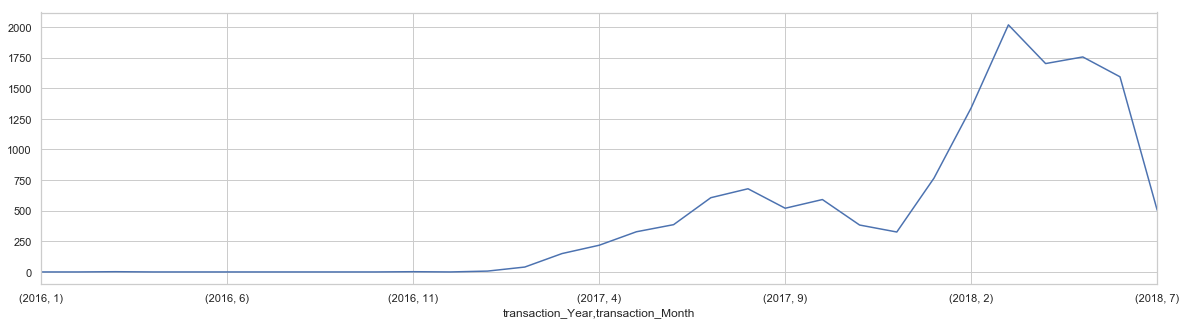

In [78]:
pd.crosstab([unifiedDF.transaction_Year,unifiedDF.transaction_Month],unifiedDF.Fraud0rNot)[1].plot(figsize=(20,5))

- there is a sudden rise in fraudulent activity from 2017 --> 2018
- However, I cannot fathom the reason of dip in fraudulent activity in the year end of 2017 as the fraudulent activities tends to increase as the festive season arrives 

% fraud and cleans 

In [82]:
unifiedDF.Fraud0rNot.value_counts(dropna=False,normalize=True)*100

False    97.820308
True      2.179692
Name: Fraud0rNot, dtype: float64

We have class im-balance so, special caution needs to be taken while modeling

# Down & Up Sampling 

In [85]:
pd.crosstab([unifiedDF.transaction_Year,unifiedDF.transaction_Month],unifiedDF.Fraud0rNot)

Fraud0rNot                          False  True 
transaction_Year transaction_Month              
2016             1                    181      0
                 2                    747      0
                 3                   1435      2
                 4                   1796      0
                 5                   2258      0
                 6                   2810      0
                 7                   4383      0
                 8                   6204      0
                 9                   5420      0
                 10                  6253      0
                 11                  6637      2
                 12                  6825      0
2017             1                   7002      7
                 2                   7479     40
                 3                   9593    150
                 4                  10130    218
                 5                  11184    328
                 6                  13462    386
                 7                  16464    606
                 8                  19248    679
                 9                  20751    520
                 10                 21539    591
                 11                 23271    383
                 12                 27500    326
2018             1                  29326    766
                 2                  31257   1340
                 3                  43428   2017
                 4                  48092   1701
                 5                  69939   1755
                 6                  78700   1593
                 7                  91119    504

## Down Sampling 

- Intuition behind down sampling is to decrease the number of clean samples from our data set
- As we can see there are only 4 identified frauds in the year 2016 and rest are clean users So, I will leave the data out of the modeling process. Based on the following hypothesis :

    1. There are very less fraud cases and statistically in-significant 
    2. The fraud scenarios are every changing and to train the model on a very old dataset won't help us with the current          fraud landscape.
- Clean users have most of the transactions associated to them thus, I will randomly choose 30% of the clean users and all transactions associated to them for modeling.

#### Removing 2016 data 

In [86]:
unifiedDF = unifiedDF[(unifiedDF.transaction_Year!=2016)].copy()

In [102]:
unifiedDF.shape

(593394, 34)

#### Clean User Random Selection 

In [96]:
from sklearn.model_selection import train_test_split

In [189]:
user_select, user_discard = train_test_split(
    unifiedDF[unifiedDF.Fraud0rNot == False].USER_ID.unique(),
    test_size=0.769,
    random_state=42)

In [190]:
user_select_df  =  unifiedDF[unifiedDF['USER_ID'].isin(list(user_select))]

In [191]:
user_select_df.shape

(125227, 34)

In [192]:
downSampleDF = user_select_df.append(unifiedDF[unifiedDF.Fraud0rNot==True]).copy()

In [193]:
del user_select_df,user_select,user_discard

In [195]:
(downSampleDF.Fraud0rNot.value_counts(dropna=False,normalize=True))*100

False    90.002659
True      9.997341
Name: Fraud0rNot, dtype: float64

#### Up Sampling 

- Up sampling is already taken care the moment I joined the transactions table with users table
- Considering all the transactions from fraudulent payee as fraud transactions 

- Writing the down sampled data to disk

In [196]:
downSampleDF.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/DownSampledDataForModeling.csv",index=False)

In [38]:
downSampleDF = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/DownSampledDataForModeling.csv")

In [70]:
downSampleDF.shape

(139137, 34)

In [39]:
downSampleDF['CREATED_DATE_x'] = pd.to_datetime(downSampleDF.CREATED_DATE_x)
downSampleDF['CREATED_DATE_y'] = pd.to_datetime(downSampleDF.CREATED_DATE_y)
downSampleDF['TERMS_VERSION']  = pd.to_datetime(downSampleDF.TERMS_VERSION)

# Train || Validation || Test 

In [222]:
downSampleDF[downSampleDF.Fraud0rNot==True].groupby(['USER_ID','transaction_Year','transaction_Month'])['transaction_Month'].count()[:10]

USER_ID                               transaction_Year  transaction_Month
0180632d-7737-42af-aaf0-95c2714d7854  2017              9                     8
018f9e74-458b-4782-8a92-5f95734ddcd7  2018              3                     2
                                                        6                    39
0238733a-732b-4353-a463-20fc1868affd  2017              10                    3
                                                        12                    1
                                      2018              1                     1
                                                        2                     1
024320ea-0cfa-4ce9-8d44-ad9fbfaf29e4  2018              4                    65
                                                        5                     4
02c91a02-8a73-4fc2-aa15-368e60ac2122  2017              7                    36
Name: transaction_Month, dtype: int64

- Since fraudulent user's transactions are spread across the data set timebased split will not work and may possibly cause data-leak
- Thus, opting to take users based split of the data set.

In [197]:
train, test= train_test_split(downSampleDF.USER_ID.unique(), test_size=0.2, random_state=42)

In [198]:
train, validation= train_test_split(train, test_size=0.2, random_state=42)

In [199]:
len(list(train)) + len(list(validation)) + len(list(test)) ==  len(downSampleDF.USER_ID.unique().tolist())

True

In [200]:
trainDF      = downSampleDF[downSampleDF['USER_ID'].isin(list(train))]
validationDF = downSampleDF[downSampleDF['USER_ID'].isin(list(validation))]
testDF       = downSampleDF[downSampleDF['USER_ID'].isin(list(test))]

In [202]:
print("train      := ", trainDF.shape)
print("validation := ", validationDF.shape)
print("test       := ", testDF.shape)

train      :=  (87308, 34)
validation :=  (22400, 34)
test       :=  (29429, 34)


In [206]:
trainDF.Fraud0rNot.value_counts(dropna=False,normalize=True)*100

False    88.52797
True     11.47203
Name: Fraud0rNot, dtype: float64

In [207]:
validationDF.Fraud0rNot.value_counts(dropna=False,normalize=True)*100

False    91.540179
True      8.459821
Name: Fraud0rNot, dtype: float64

In [208]:
testDF.Fraud0rNot.value_counts(dropna=False,normalize=True)*100

False    93.20738
True      6.79262
Name: Fraud0rNot, dtype: float64

###### Write Data to disk 

In [209]:
trainDF.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/trainDF.csv",index=False)
validationDF.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/validationDF.csv",index=False)
testDF.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/testDF.csv",index=False)

In [210]:
del downSampleDF,validationDF,testDF

### Load TrainDF 

In [4]:
trainDF = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/trainDF.csv")
trainDF['CREATED_DATE_x'] = pd.to_datetime(trainDF.CREATED_DATE_x)
trainDF['CREATED_DATE_y'] = pd.to_datetime(trainDF.CREATED_DATE_y)
trainDF['TERMS_VERSION']  = pd.to_datetime(trainDF.TERMS_VERSION)

In [214]:
trainDF.isnull().sum().sort_values(ascending=False)[:5]

MERCHANT_CATEGORY    59816
Fraud0rNot               0
TYPE                     0
PHONE_COUNTRY            0
HAS_EMAIL                0
dtype: int64

In [217]:
trainDF.dtypes

CURRENCY                           object
AMOUNT                              int64
STATE_x                            object
CREATED_DATE_x             datetime64[ns]
MERCHANT_CATEGORY                  object
MERCHANT_COUNTRY                   object
ENTRY_METHOD                       object
USER_ID                            object
TYPE                               object
SOURCE                             object
ID_x                               object
AMOUNT_USD                          int64
ID_y                               object
HAS_EMAIL                           int64
PHONE_COUNTRY                      object
TERMS_VERSION              datetime64[ns]
CREATED_DATE_y             datetime64[ns]
STATE_y                            object
COUNTRY                            object
BIRTH_YEAR                          int64
KYC                                object
FAILED_SIGN_IN_ATTEMPTS             int64
CODE                               object
NAME                              

# User Behavioural Analysis 

### User's Amount(USD)

In [224]:
trainDF.groupby('USER_ID').agg({'AMOUNT_USD':['mean',np.std]}).reset_index()[:10]

USER_ID     AMOUNT_USD               
                                                  mean            std
0  0022f893-47c7-4da0-96df-7ea564bfd50d    8875.561644   17973.118306
1  00870274-9ca1-4c1a-9db2-728e3dcc03f8   15370.025641   24124.253986
2  00b47064-e530-4efd-8cfe-0bad54fc9a9b     882.000000     654.715205
3  0180632d-7737-42af-aaf0-95c2714d7854  139078.125000  175536.564830
4  0181835b-4193-44fe-97e2-cb791693567c    5923.809524   10039.066000
5  018f9e74-458b-4782-8a92-5f95734ddcd7  145153.560976  230711.787587
6  019ae1cb-4052-47cf-b190-daf00586529b     263.375000     740.904647
7  01a88aa0-18b4-4b91-accb-81679a76a32e    1901.283871    4415.049650
8  01f36078-07dc-40fa-9b3b-cf3a724b4847    1685.000000            NaN
9  0225460a-a10e-4210-8267-e016b3269440    5820.264706   15967.628109

idea behind calculating the user mean and std is to find the Z-Score of the current transactions such that we can find the anomalous transaction

### User Amount(USD) per hour of day

In [227]:
trainDF['trx_hour_of_day'] = pd.Series(trainDF.CREATED_DATE_x.dt.hour).copy()

In [228]:
trainDF.groupby(['USER_ID','trx_hour_of_day']).agg({'AMOUNT_USD':['mean',np.std]})[:10]

AMOUNT_USD  \
                                                              mean   
USER_ID                              trx_hour_of_day                 
0022f893-47c7-4da0-96df-7ea564bfd50d 0                22775.666667   
                                     1                 2099.000000   
                                     2                 4026.500000   
                                     3                 3873.500000   
                                     5                 6656.000000   
                                     8                 1260.000000   
                                     9                 7589.000000   
                                     10                3700.000000   
                                     11                1008.000000   
                                     12                1204.000000   

                                                                    
                                                               std  
USER_ID                              trx_hour_of_day                
0022f893-47c7-4da0-96df-7ea564bfd50d 0                39987.539027  
                                     1                 1745.258434  
                                     2                 5330.235173  
                                     3                 2790.950465  
                                     5                         NaN  
                                     8                         NaN  
                                     9                         NaN  
                                     10                        NaN  
                                     11                 356.381818  
                                     12                        NaN

### USer Amount(USD) per day of week

In [229]:
trainDF['trx_day_of_week'] = pd.Series(trainDF.CREATED_DATE_x.dt.dayofweek).copy()

In [230]:
trainDF.groupby(['USER_ID','trx_day_of_week']).agg({'AMOUNT_USD':['mean',np.std]})[:10]

AMOUNT_USD  \
                                                              mean   
USER_ID                              trx_day_of_week                 
0022f893-47c7-4da0-96df-7ea564bfd50d 0                 1326.600000   
                                     1                 7757.250000   
                                     2                12443.785714   
                                     3                 1801.500000   
                                     4                 8786.444444   
                                     5                 7462.666667   
                                     6                15848.333333   
00870274-9ca1-4c1a-9db2-728e3dcc03f8 0                 1260.000000   
                                     1                18660.000000   
                                     2                  596.000000   

                                                                    
                                                               std  
USER_ID                              trx_day_of_week                
0022f893-47c7-4da0-96df-7ea564bfd50d 0                  933.195133  
                                     1                 8238.839911  
                                     2                12855.309380  
                                     3                 1412.553817  
                                     4                11142.069502  
                                     5                 6439.679845  
                                     6                35236.282051  
00870274-9ca1-4c1a-9db2-728e3dcc03f8 0                         NaN  
                                     1                19433.148238  
                                     2                         NaN

- Basic motivation is generally human beings follow a trend while spending money and that can be captured via these metrics and if any transaction is made which fall out of that trend shall be highlighted via Z-Score calculation

In [231]:
users.head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,2017-08-09 15:03:33.945000,ACTIVE,GB,1989,PASSED,0


### USer's Phone Country count

In [235]:
pd.Series(trainDF.PHONE_COUNTRY.str.count('\|\|')+1)[:5]

0    1
1    1
2    4
3    4
4    4
Name: PHONE_COUNTRY, dtype: int64

In [234]:
trainDF['Phone_Country_Count'] = pd.Series(trainDF.PHONE_COUNTRY.str.count('\|\|')+1)

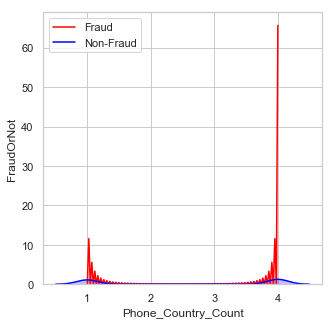

In [237]:
plt.figure(figsize=(5, 5))
g = sns.kdeplot(trainDF["Phone_Country_Count"][(trainDF["Fraud0rNot"] == True)
                                     & (trainDF["Phone_Country_Count"].notnull())
                                      ],
                color="Red",
                shade=True)
g = sns.kdeplot(trainDF["Phone_Country_Count"][(trainDF["Fraud0rNot"] == False)
                                     & (trainDF["Phone_Country_Count"].notnull())
                                    
                                     ],
                ax=g,
                color="Blue",
                shade=True)
g.set_xlabel("Phone_Country_Count")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

- we can observe a clear spike for users having phone country more than 1 

#### USer Country Count

In [251]:
trainDF.groupby(['USER_ID','COUNTRY']).agg({'COUNTRY':['nunique']}).reset_index().sort_values(by=[('COUNTRY', 'nunique')],ascending=False)[:10]

USER_ID COUNTRY        
                                                  nunique
0    0022f893-47c7-4da0-96df-7ea564bfd50d      GB       1
827  ae4ac6e4-0d71-4108-98ec-0883da6a120a      LT       1
834  b0601beb-95d5-4a16-957d-bf7e5c41e840      CH       1
833  afe728a5-31ba-4fae-9ce0-3f4ff1fa97b0      GB       1
832  af730027-3230-4c5d-8a15-1ff94d063261      GB       1
831  af6f5c97-2935-4449-9ca7-0fd586e882be      GB       1
830  aef948da-48b5-4985-8b7e-b939c85f048e      BE       1
829  aee96b8e-97fc-4a14-94fb-0ee436e0272d      GB       1
828  aec1904b-2347-4826-88b2-f7a53ca7d802      GB       1
826  ae435217-a5fd-4031-8350-ffb1958bf673      IE       1

- seems users belong to a specific country only 

#### Count of Currency Used By the User

In [255]:
trainDF.groupby(['USER_ID'])['CURRENCY'].nunique().reset_index().sort_values(by='CURRENCY',ascending=False)[:10]

,USER_ID,CURRENCY
47,07f68c2b-c289-48aa-ae42-fa997cbf15a3,6
811,ab00cdd5-b99e-440d-9f8a-e6a12361a036,6
367,4bae22fe-0cb0-45c8-a8e0-88ff1669b131,5
1171,f296ccda-4f6c-4d18-b529-9a0d4dd7255c,5
726,99966941-c012-4cb9-aa15-64fd60aa0295,5
224,2fa74422-972a-4e28-adf4-104ae9d68e27,5
943,c66d03e5-3f2c-45c7-8ca4-11beed288138,5
311,40c40dac-b6b3-4b62-a80e-8dab83a2703e,5
978,cefaa732-ac64-4f36-ba89-2ac7049ec12a,5
147,1b8e7803-696c-4dbf-8836-e0a89c151732,5


- there are users which have multiple currency used

# Fraud Analysis 

### Fraud Distribution 

False    88.52797
True     11.47203
Name: Fraud0rNot, dtype: float64


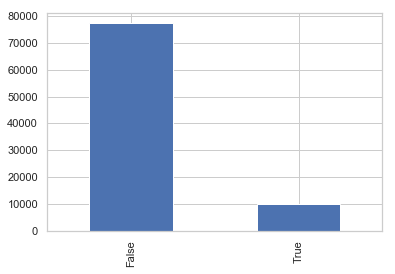

In [256]:
trainDF.Fraud0rNot.value_counts(dropna=False).plot(kind='bar')
print(trainDF.Fraud0rNot.value_counts(dropna=False,normalize=True)*100)

### Fraud Distribution Over Time Period

#### Fraud Distribution Over Month 

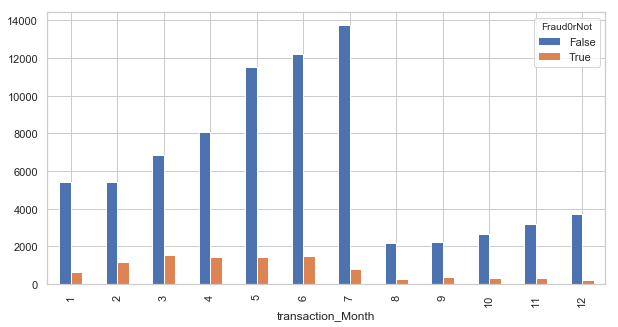

In [274]:
pd.crosstab(trainDF.transaction_Month,trainDF.Fraud0rNot,dropna=False).plot(kind='bar',figsize=(10,5))

- we see the rise in transaction count in the mid year period and thus, the rise in fraudulent cases.

#### Fraud Distribution Over Dates and Weeks

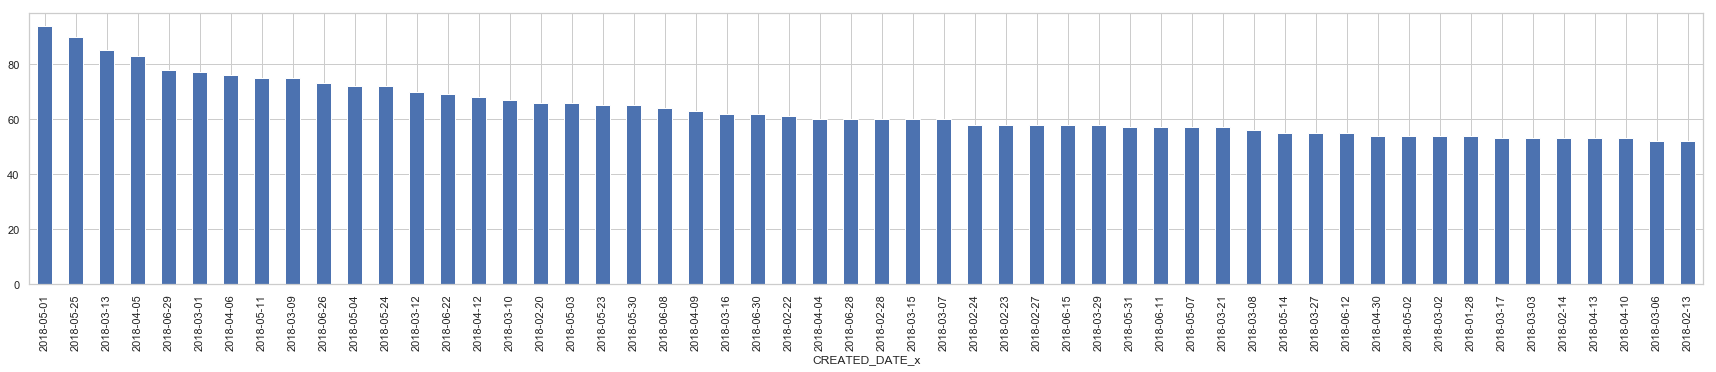

In [273]:
(pd.crosstab(trainDF.CREATED_DATE_x.dt.date,
             trainDF.Fraud0rNot,
             normalize=False)[1].sort_values(ascending=False)).compress(lambda x: x > 50).plot(kind='bar',
                                                                  figsize=(30,
                                                                           5))

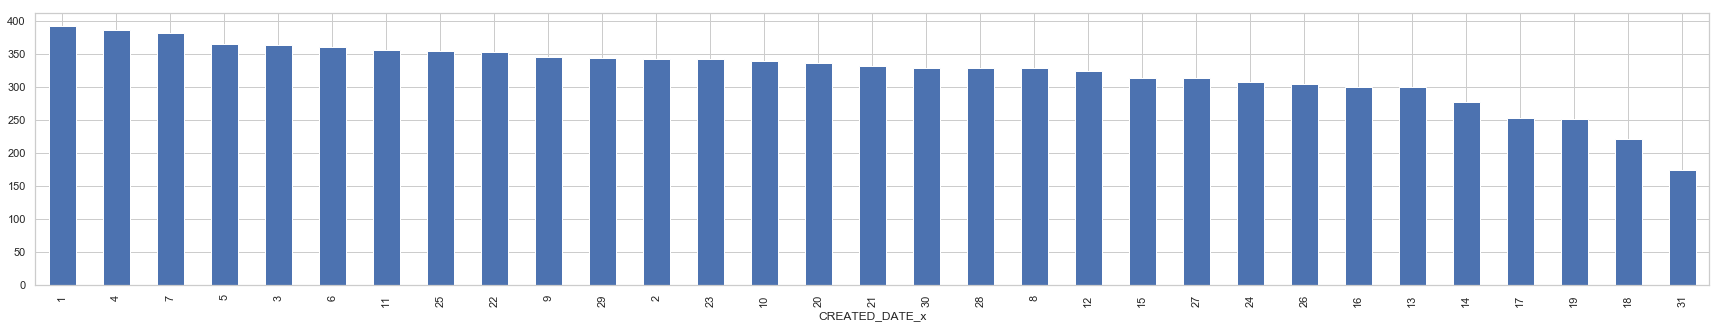

In [272]:
pd.crosstab(trainDF.CREATED_DATE_x.dt.day,
             trainDF.Fraud0rNot,
             normalize=False)[1].sort_values(ascending=False).plot(kind='bar',
                                                                  figsize=(30,
                                                                           5))

- we can see starting days of the month and then end days of the month have high surge in the fraudulent activities 

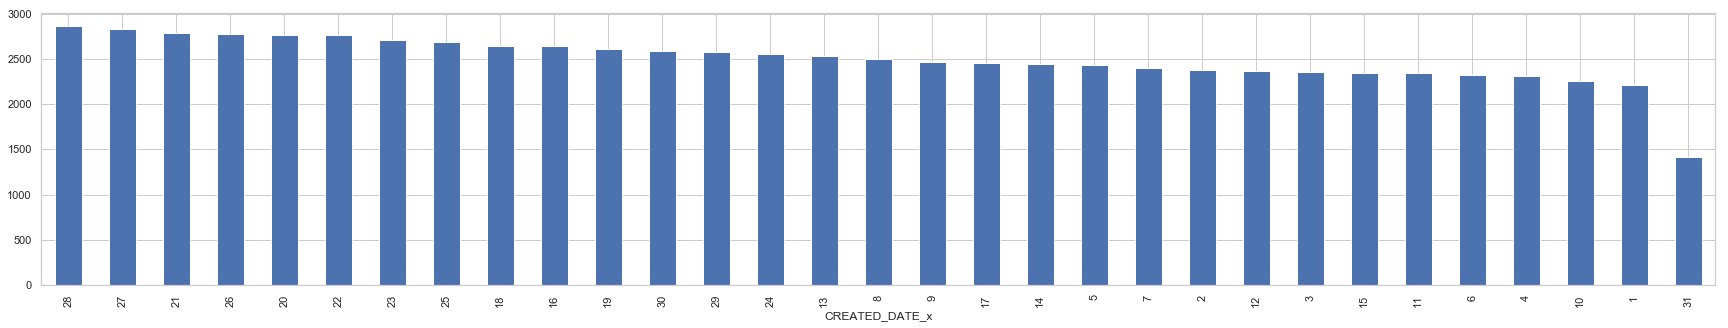

In [271]:
pd.crosstab(trainDF.CREATED_DATE_x.dt.day,
             trainDF.Fraud0rNot,
             normalize=False)[0].sort_values(ascending=False).plot(kind='bar',
                                                                  figsize=(30,
                                                                           5))

- However the clean transactions have high traffic in the month end days 

In [270]:
impFunctions.calculateLiftDiscrete(
    [trainDF.CREATED_DATE_x.dt.day, trainDF.CREATED_DATE_x.dt.dayofweek],
    trainDF.Fraud0rNot, ['dayOfMonth', 'dayOfWeek']).sort_values(by='lift',ascending=False)[:10]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
0,dayOfMonth,1,2600,0.029780,392,2208,0.1508,0.0391,1.37
3,dayOfMonth,4,2702,0.030948,386,2316,0.1429,0.0385,1.29
6,dayOfMonth,7,2785,0.031899,381,2404,0.1368,0.0380,1.22
5,dayOfMonth,6,2680,0.030696,361,2319,0.1347,0.0360,1.20
2,dayOfMonth,3,2715,0.031097,363,2352,0.1337,0.0362,1.19
10,dayOfMonth,11,2696,0.030879,356,2340,0.1320,0.0355,1.17
4,dayOfMonth,5,2798,0.032047,365,2433,0.1305,0.0364,1.16
9,dayOfMonth,10,2596,0.029734,339,2257,0.1306,0.0338,1.16
33,dayOfWeek,2,12384,0.141843,1572,10812,0.1269,0.1569,1.12
34,dayOfWeek,3,12775,0.146321,1616,11159,0.1265,0.1613,1.12


- as expected we can see high lift for day of month and also high detection rate for  day of week variables 

#### Fraud distribution over Hour of Day

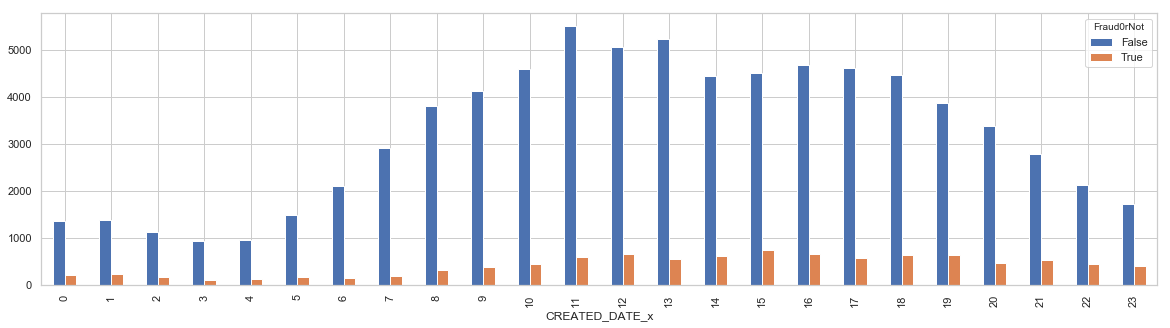

In [276]:
pd.crosstab(trainDF.CREATED_DATE_x.dt.hour,trainDF.Fraud0rNot,dropna=False).plot(kind='bar',figsize=(20,5))

- we can see as the decline in the traffic post regular office hours however, the fraud count is comparatively high in the non-office hours

In [277]:
impFunctions.calculateLiftDiscrete(
    [trainDF.CREATED_DATE_x.dt.hour],
    trainDF.Fraud0rNot, ['hourOfDay']).sort_values(by='lift',ascending=False)[:10]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
23,hourOfDay,23,2136,0.024465,412,1724,0.1929,0.0411,1.84
22,hourOfDay,22,2577,0.029516,439,2138,0.1704,0.0438,1.58
21,hourOfDay,21,3322,0.038049,536,2786,0.1613,0.0535,1.48
1,hourOfDay,1,1612,0.018463,233,1379,0.1445,0.0233,1.30
19,hourOfDay,19,4521,0.051782,639,3882,0.1413,0.0638,1.27
15,hourOfDay,15,5242,0.060040,738,4504,0.1408,0.0737,1.26
0,hourOfDay,0,1565,0.017925,212,1353,0.1355,0.0212,1.21
2,hourOfDay,2,1286,0.014729,163,1123,0.1267,0.0163,1.12
18,hourOfDay,18,5105,0.058471,635,4470,0.1244,0.0634,1.10
16,hourOfDay,16,5351,0.061289,664,4687,0.1241,0.0663,1.09


1. We can observe high lift in the non-office hours 

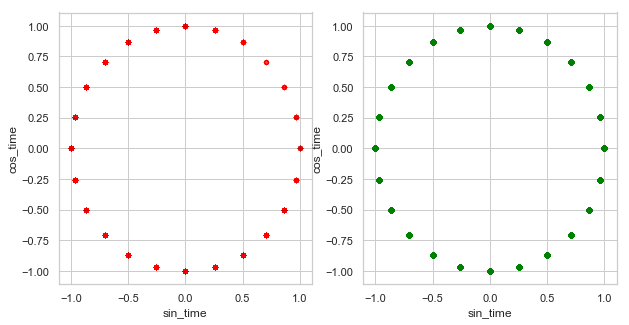

In [288]:
trainDF['sin_time'] = np.sin(trainDF.CREATED_DATE_x.dt.hour*(2.*np.pi/24))
trainDF['cos_time'] = np.cos(trainDF.CREATED_DATE_x.dt.hour*(2.*np.pi/24))
fig,axarr = plt.subplots(1,2,figsize=(10,5))
trainDF[trainDF.Fraud0rNot==True].plot.scatter('sin_time','cos_time',ax=axarr[0],color='red',alpha=0.01)
trainDF[trainDF.Fraud0rNot==False].plot.scatter('sin_time','cos_time',ax=axarr[1],color='green')
plt.close(2)
plt.close(3)

- seems fraud and clean transactions are happening round the clock and we cannot see any obvious separation here

# Exploratory Data Analysis 

## AMOUNT_USD || AMOUNT

### Amount(USD) vs Fraud 

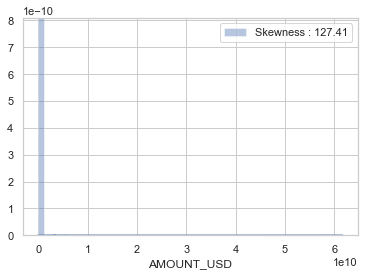

In [289]:
g = sns.distplot(trainDF["AMOUNT_USD"], color="b", label="Skewness : %.2f"%(trainDF["AMOUNT_USD"].skew()))
g = g.legend(loc="best")

- it seems there are outliers in the Amount(USD)
- Amount is highly right skewed 

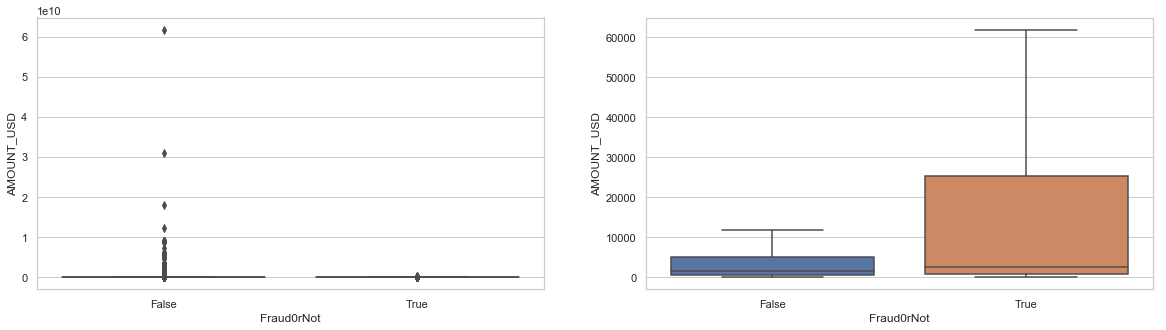

In [291]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))

sns.factorplot(y='AMOUNT_USD',
               x='Fraud0rNot',
               data=trainDF,
               kind='box',
               size=15,
               aspect=.4,
               showfliers=True,
               ax=axarr[0])
sns.factorplot(y='AMOUNT_USD',
               x='Fraud0rNot',
               data=trainDF,
               kind='box',
               size=15,
               aspect=.4,
               showfliers=False,
               ax=axarr[1])
plt.close(2)
plt.close(3)

In [296]:
trainDF[trainDF.Fraud0rNot==True].AMOUNT_USD.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.99])

count    1.001600e+04
mean     7.321793e+04
std      2.350469e+06
min      0.000000e+00
10%      1.260000e+02
20%      3.760000e+02
30%      8.810000e+02
40%      1.260000e+03
50%      2.513000e+03
60%      4.916000e+03
70%      1.260600e+04
80%      3.529900e+04
99%      5.663616e+05
max      1.936564e+08
Name: AMOUNT_USD, dtype: float64

In [297]:
trainDF[trainDF.Fraud0rNot==False].AMOUNT_USD.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.99])

count    7.729200e+04
mean     7.609971e+06
std      3.138159e+08
min      0.000000e+00
10%      1.260000e+02
20%      3.700000e+02
30%      6.320000e+02
40%      1.046000e+03
50%      1.419000e+03
60%      2.266000e+03
70%      3.782000e+03
80%      6.303000e+03
99%      1.260680e+05
max      6.167100e+10
Name: AMOUNT_USD, dtype: float64

- this shows if we keep simple filter on 50th percentile of fraud amount we will get ride of 60% of the clean traffic hence, reducing the False positives

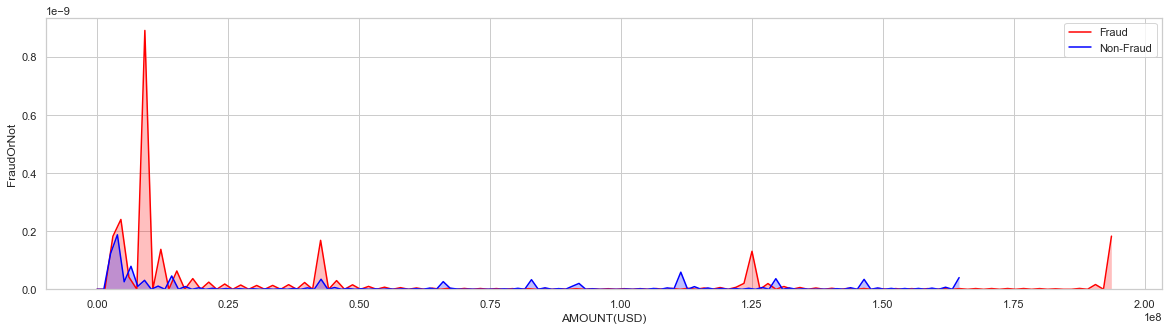

In [300]:
plt.figure(figsize=(20, 5))
g = sns.kdeplot(
    trainDF["AMOUNT_USD"][(trainDF["Fraud0rNot"] == True)
                          & (trainDF["AMOUNT_USD"].notnull())
                          & (trainDF["AMOUNT_USD"] > 2.513000e+03) &
                          (trainDF["AMOUNT_USD"] < 1.936564e+08)],
    color="Red",
    shade=True)
g = sns.kdeplot(
    trainDF["AMOUNT_USD"][(trainDF["Fraud0rNot"] == False)
                          & (trainDF["AMOUNT_USD"].notnull())
                          & (trainDF["AMOUNT_USD"] > 2.513000e+03) &
                          (trainDF["AMOUNT_USD"] < 1.936564e+08)],
    ax=g,
    color="Blue",
    shade=True)
g.set_xlabel("AMOUNT(USD)")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

- We can clearly see the peeks in fraud amount 

In [303]:
trainDF[trainDF.AMOUNT_USD > 1.936564e+08].Fraud0rNot.value_counts()

False    134
Name: Fraud0rNot, dtype: int64

The outlier amount is all clean and is causing high skewness thus, I am choosing to drop these records

In [306]:
trainDF.shape

(87308, 39)

In [307]:
trainDF = trainDF[trainDF.AMOUNT_USD <= 1.936564e+08].copy()

In [308]:
trainDF.shape

(87174, 39)

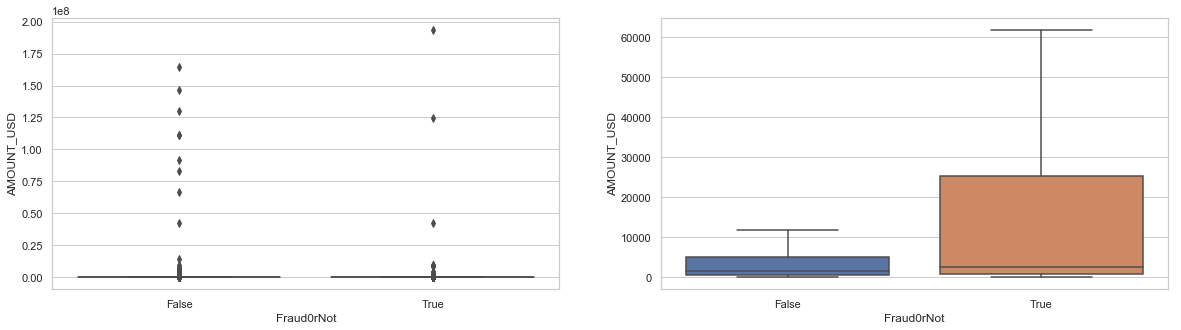

In [309]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))

sns.factorplot(y='AMOUNT_USD',
               x='Fraud0rNot',
               data=trainDF,
               kind='box',
               size=15,
               aspect=.4,
               showfliers=True,
               ax=axarr[0])
sns.factorplot(y='AMOUNT_USD',
               x='Fraud0rNot',
               data=trainDF,
               kind='box',
               size=15,
               aspect=.4,
               showfliers=False,
               ax=axarr[1])
plt.close(2)
plt.close(3)

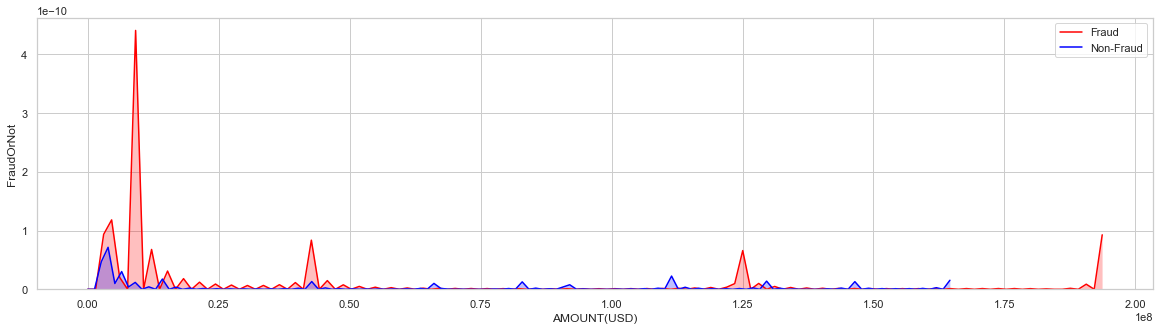

In [310]:
plt.figure(figsize=(20, 5))
g = sns.kdeplot(
    trainDF["AMOUNT_USD"][(trainDF["Fraud0rNot"] == True)
                          & (trainDF["AMOUNT_USD"].notnull())
                         ],
    color="Red",
    shade=True)
g = sns.kdeplot(
    trainDF["AMOUNT_USD"][(trainDF["Fraud0rNot"] == False)
                          & (trainDF["AMOUNT_USD"].notnull())
                         ],
    ax=g,
    color="Blue",
    shade=True)
g.set_xlabel("AMOUNT(USD)")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

 - as we can see post removal of the outlier we can see obvious separation between clean and Fraud Amount(USD)

In [313]:
trainDF.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/trainDF.csv",index=False)

### Amount(USD) First and Last Digit Analysis

#### First Digit 

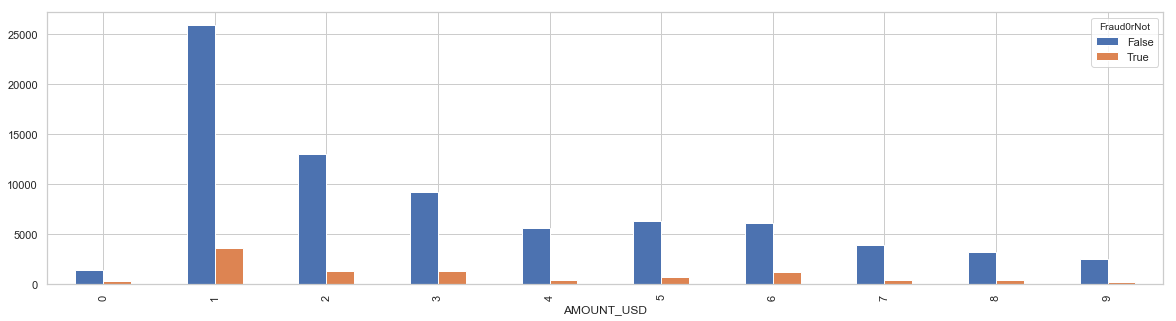

In [311]:
pd.crosstab(trainDF.AMOUNT_USD.apply(lambda x : str(x)[0]),trainDF.Fraud0rNot).plot(kind='bar',figsize=(20,5))

- We can see some difference for fraud and clean for first digits as 6,3,5

#### Last Digit

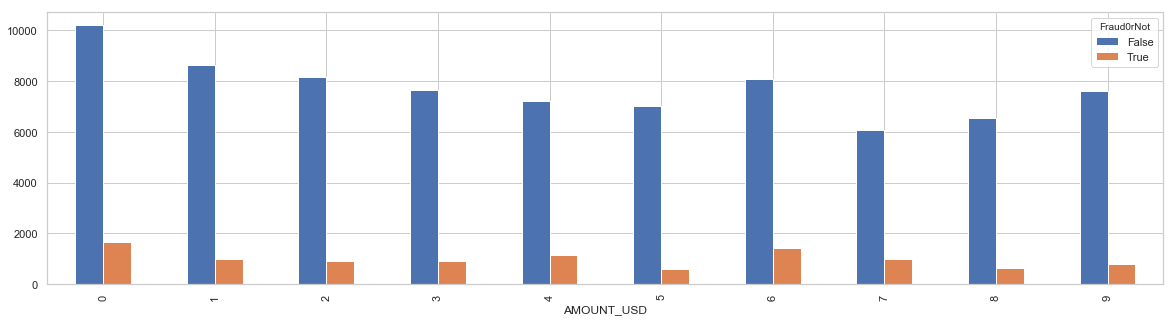

In [312]:
pd.crosstab(trainDF.AMOUNT_USD.apply(lambda x : str(x)[-1]),trainDF.Fraud0rNot).plot(kind='bar',figsize=(20,5))

- For last digit we can see high value for 4,6,9 
- Let's check their lift ratio

In [314]:
impFunctions.calculateLiftDiscrete(
    [trainDF.AMOUNT_USD.apply(lambda x : str(x)[0]),trainDF.AMOUNT_USD.apply(lambda x : str(x)[-1])],
    trainDF.Fraud0rNot, ['Amount_USD_First_Digit','Amount_USD_Last_Digit']).sort_values(by='lift',ascending=False)[:10]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
0,Amount_USD_First_Digit,0,1714,0.019662,328,1386,0.1914,0.0327,1.82
6,Amount_USD_First_Digit,6,7371,0.084555,1236,6135,0.1677,0.1234,1.55
16,Amount_USD_Last_Digit,6,9496,0.108932,1416,8080,0.1491,0.1414,1.35
17,Amount_USD_Last_Digit,7,7076,0.081171,999,6077,0.1412,0.0997,1.27
14,Amount_USD_Last_Digit,4,8367,0.095980,1158,7209,0.1384,0.1156,1.24
10,Amount_USD_Last_Digit,0,11840,0.135820,1640,10200,0.1385,0.1637,1.24
3,Amount_USD_First_Digit,3,10605,0.121653,1349,9256,0.1272,0.1347,1.12
1,Amount_USD_First_Digit,1,29515,0.338576,3620,25895,0.1226,0.3614,1.08
8,Amount_USD_First_Digit,8,3625,0.041583,396,3229,0.1092,0.0395,0.94
13,Amount_USD_Last_Digit,3,8537,0.097931,895,7642,0.1048,0.0894,0.90


- As expected we could see high lift on first and last digit as 6 

- Since, we see high lift for first digit less than 1 that may point that fruad is happening in there local currency

### Amount(USD) & Amount

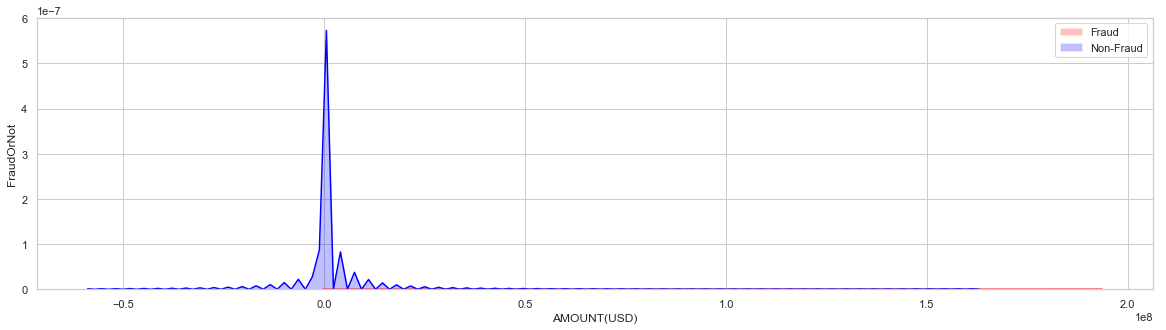

In [316]:
plt.figure(figsize=(20, 5))
g = sns.kdeplot((trainDF["AMOUNT_USD"] -
                 trainDF["AMOUNT"])[(trainDF["Fraud0rNot"] == True)],
                color="Red",
                shade=True)
g = sns.kdeplot((trainDF["AMOUNT_USD"] -
                 trainDF["AMOUNT"])[(trainDF["Fraud0rNot"] == False)],
                ax=g,
                color="Blue",
                shade=True)
g.set_xlabel("AMOUNT(USD)")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

- We can see the long tail for fraud amount where the difference is high 

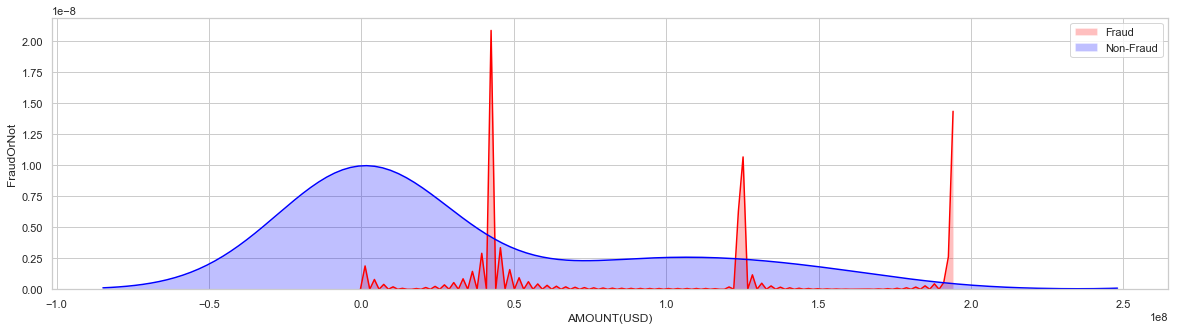

In [318]:
plt.figure(figsize=(20, 5))
g = sns.kdeplot(
     (trainDF["AMOUNT_USD"]-trainDF["AMOUNT"])[(trainDF["Fraud0rNot"] == True)
                          & ((trainDF["AMOUNT_USD"]-trainDF["AMOUNT"]) > 150000)
                         ],
    color="Red",
    shade=True)
g = sns.kdeplot(
     (trainDF["AMOUNT_USD"]-trainDF["AMOUNT"])[(trainDF["Fraud0rNot"] == False)
                          & ((trainDF["AMOUNT_USD"]-trainDF["AMOUNT"]) > 150000)
                         ],
    ax=g,
    color="Blue",
    shade=True)
g.set_xlabel("AMOUNT(USD)")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

- We can clearly see the peaks for certain amount difference

## CURRENCY

In [321]:
trainDF.CURRENCY.value_counts(dropna=False,normalize=True)[:5]*100

GBP    53.318650
EUR    35.298369
PLN     3.995457
USD     3.332416
RON     1.297405
Name: CURRENCY, dtype: float64

In [425]:
pd.crosstab(trainDF.CURRENCY,trainDF.Fraud0rNot).sort_values(1,ascending=False)[:10]

Fraud0rNot,False,True
CURRENCY,,
GBP,37270,9210
EUR,30298,473
PLN,3191,292
USD,2875,30
RON,1125,6
BTC,5,3
CHF,877,1
CZK,139,1
AED,25,0


- It seems that most of the fraud and clean traffic is from Europe and UK  

In [325]:
pd.crosstab(np.where(((trainDF.CURRENCY!='GBP')&(trainDF.CURRENCY!='EUR')),1,0),trainDF.Fraud0rNot)

Fraud0rNot,False,True
row_0,,
0,67568,9683
1,9590,333


In [327]:
impFunctions.calculateLiftDiscrete([
    pd.Series(np.where(((trainDF.CURRENCY!='GBP')&(trainDF.CURRENCY!='EUR')),1,0))
], trainDF.Fraud0rNot, ['CurrencyNotUKorEU'])

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
0,CurrencyNotUKorEU,0,77251,0.88617,9550,67586,0.1236,0.9535,1.09
1,CurrencyNotUKorEU,1,9923,0.11383,332,9572,0.0335,0.0331,0.27


Not much lift observed in the Currency Columns

## STATE_X

- This column will not be used in the ML modeling as this is tagged to a transaction only as a post detection task thus, we will not have access to the variable at the detection is undergoing.
- However, this column can be used for creating rules as Phase A detection process for users who have locked state in the past and if it's recent past then will have more suspicion associated to it 

Fraud0rNot  False  True 
STATE_x                 
CANCELLED      55     12
COMPLETED   65531   7370
DECLINED     4475   1503
FAILED       2168    310
PENDING       357      5
REVERTED     4572    816


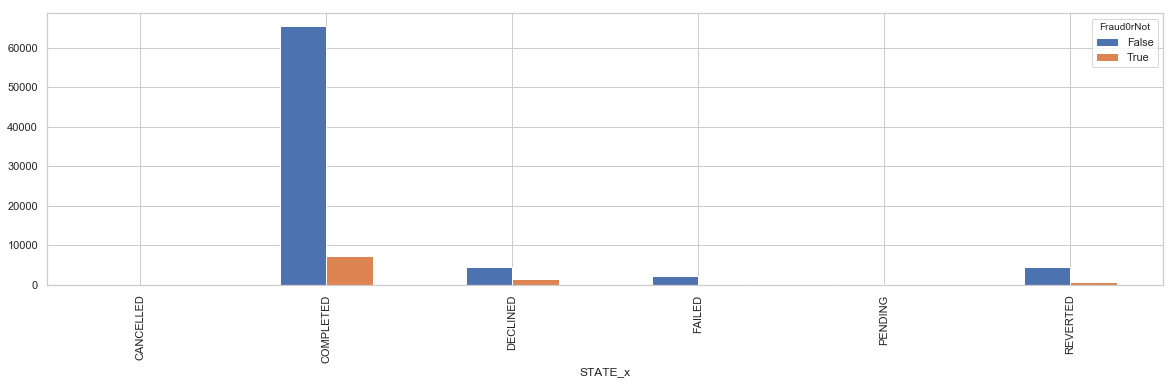

In [330]:
print(pd.crosstab(trainDF.STATE_x,trainDF.Fraud0rNot))
pd.crosstab(trainDF.STATE_x,trainDF.Fraud0rNot).plot(kind='bar',figsize=(20,5))

## MERCHANT_CATEGORY || MERCHANT_COUNTRY

Fraud0rNot          False  True 
MERCHANT_CATEGORY_              
card_payment        26597   2731
topup               15208   2356
atm                  4037   1440
bank_transfer        1913    910
point_of_interest    3748    628
p2p                  6090    359
supermarket          3960    316
restaurant           2760    160
bank                  527    152
convenience_store     742    120
gas_station           398     76
accounting              9     70
airport               302     68
cafe                 1661     61
bar                  1302     56
store                 949     55
campground             28     51
finance                51     35
florist               125     32
clothing_store        581     30


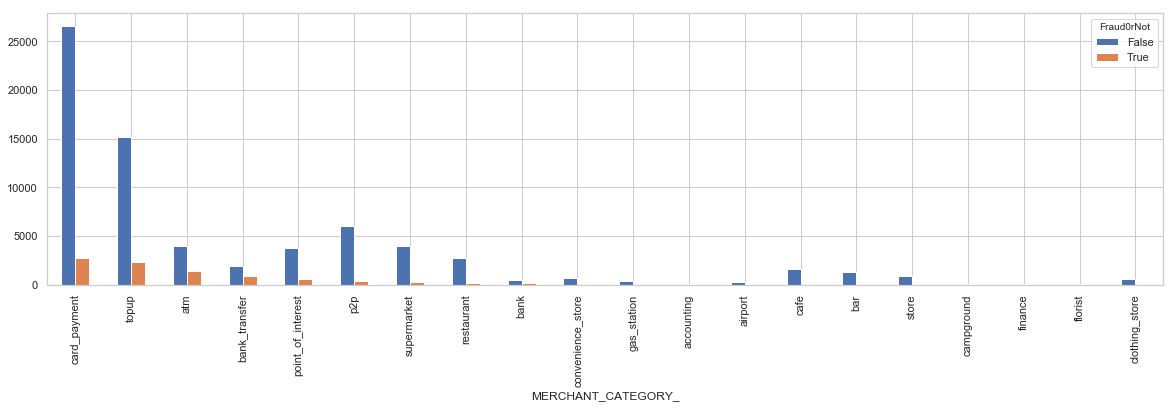

In [335]:
print(pd.crosstab(trainDF.MERCHANT_CATEGORY_,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:20])
pd.crosstab(trainDF.MERCHANT_CATEGORY_, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:20].plot(kind='bar', figsize=(20, 5))

- we can see the clean and fraud traffic are high for card payment and top-ups however, there certain categories where fraud is very high in compare to respective clean transactions ex: accounting, finance etc..

Fraud0rNot        False  True 
MERCHANT_COUNTRY              
GBR               18127   4876
_MISS             23218   3627
IRL                2002    286
POL                1556    283
NLD                2245    169
LTU                2544    165
LUX                 948     92
ESP                2056     92
USA                4443     73
DEU                1307     70
GIB                  17     67
CYP                 312     64
AUT                 130     44
MLT                 318     23
ROM                 811     15
BRA                 371     13
CHE                 691     11
MDA                   0      9
CZE                 226      6
FRA                2962      6


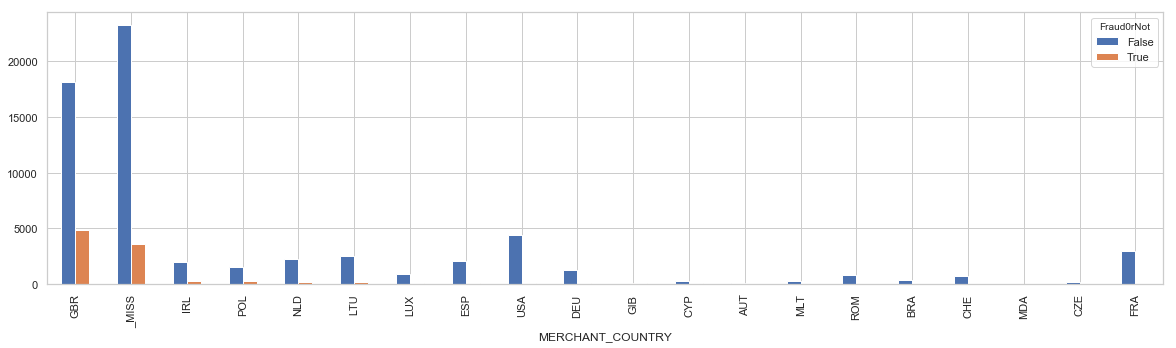

In [338]:
print(pd.crosstab(trainDF.MERCHANT_COUNTRY,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:20])
pd.crosstab(trainDF.MERCHANT_COUNTRY, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:20].plot(kind='bar', figsize=(20, 5))

- As we can see that there are high fraud transactions where country is missing however, the cleans are also high
- Let's check there corresponding lift 

In [337]:
impFunctions.calculateLiftDiscrete([
    trainDF.MERCHANT_CATEGORY_,
    trainDF.MERCHANT_COUNTRY
], trainDF.Fraud0rNot, ['MERCHANT_CATEGORY_', 'MERCHANT_COUNTRY'
                        ]).sort_values(by='lift', ascending=False)[:20]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
190,MERCHANT_COUNTRY,MDA,9,0.000103,9,0,1.0000,0.0009,inf
0,MERCHANT_CATEGORY_,accounting,79,0.000906,70,9,0.8861,0.0070,59.92
157,MERCHANT_COUNTRY,GIB,84,0.000964,67,17,0.7976,0.0067,30.36
19,MERCHANT_CATEGORY_,campground,79,0.000906,51,28,0.6456,0.0051,14.03
39,MERCHANT_CATEGORY_,finance,86,0.000987,35,51,0.4070,0.0035,5.29
53,MERCHANT_CATEGORY_,jewelry_store,13,0.000149,5,8,0.3846,0.0005,4.81
11,MERCHANT_CATEGORY_,bank_transfer,2823,0.032384,910,1913,0.3224,0.0909,3.66
8,MERCHANT_CATEGORY_,atm,5477,0.062828,1440,4037,0.2629,0.1438,2.75
120,MERCHANT_COUNTRY,AUT,174,0.001996,44,130,0.2529,0.0044,2.61
10,MERCHANT_CATEGORY_,bank,679,0.007789,152,527,0.2239,0.0152,2.22


- We see high Lift for public places merchant or card access device example 
    1. gas_station
    2. airport
    3. subway_station
 
- this can be "Skimming Card Cases" 

## ENTRY MODE

Fraud0rNot    False  True 
ENTRY_METHOD              
misc          24546   3791
manu          10636   2470
chip          19755   2246
cont          20118   1506
mags           2047      3
mcon             56      0


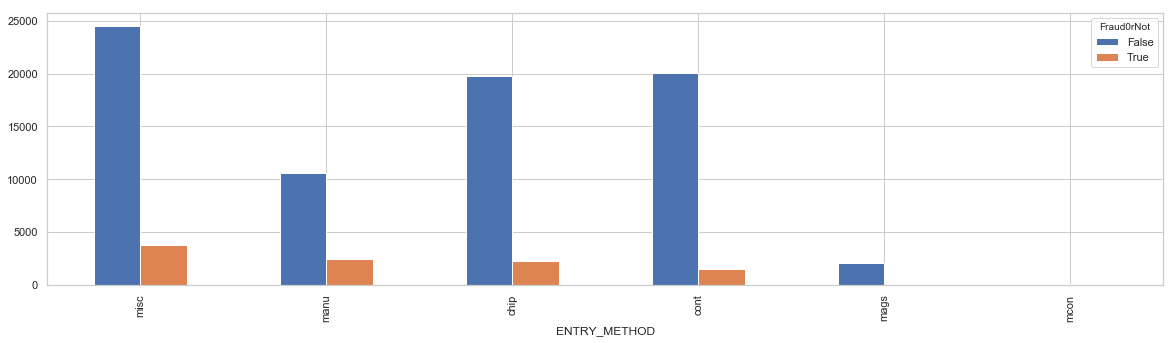

In [341]:
print(pd.crosstab(trainDF.ENTRY_METHOD,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:20])
pd.crosstab(trainDF.ENTRY_METHOD, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:20].plot(kind='bar', figsize=(20, 5))

In [340]:
impFunctions.calculateLiftDiscrete([trainDF.ENTRY_METHOD], trainDF.Fraud0rNot,
                                   ['Entry-Method']).sort_values(
                                       'lift', ascending=False)

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
3,Entry-Method,manu,13106,0.150343,2470,10636,0.1885,0.2466,1.79
5,Entry-Method,misc,28337,0.325063,3791,24546,0.1338,0.3785,1.19
0,Entry-Method,chip,22001,0.252380,2246,19755,0.1021,0.2242,0.88
1,Entry-Method,cont,21624,0.248056,1506,20118,0.0696,0.1504,0.58
2,Entry-Method,mags,2050,0.023516,3,2047,0.0015,0.0003,0.01
4,Entry-Method,mcon,56,0.000642,0,56,0.0000,0.0000,0.00


- we can high lift for Manual entry mode as the person entering the card details are committing these fraud by stealing the information form mag strip of the card or via other means

## TYPE

Fraud0rNot     False  True 
TYPE                       
CARD_PAYMENT   49648   4784
TOPUP          15208   2356
ATM             4299   1607
BANK_TRANSFER   1913    910
P2P             6090    359


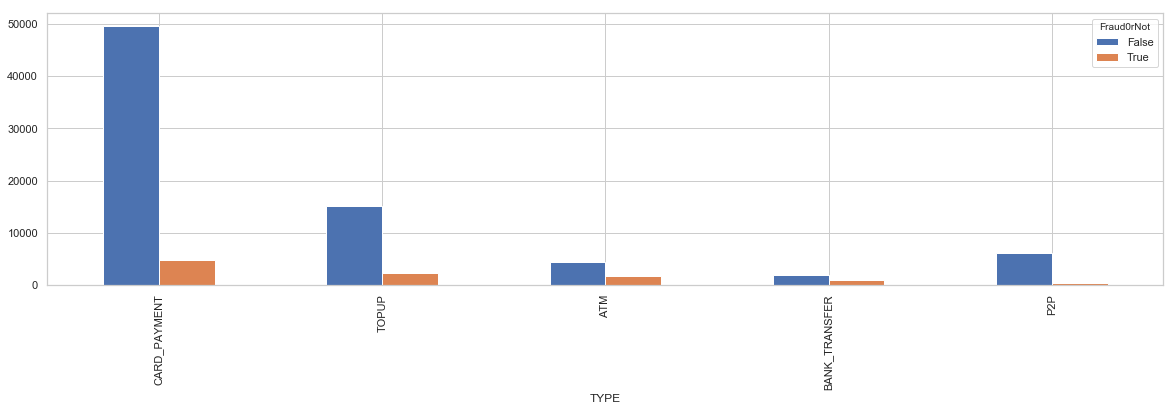

In [342]:
print(pd.crosstab(trainDF.TYPE,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:20])
pd.crosstab(trainDF.TYPE, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:20].plot(kind='bar', figsize=(20, 5))

In [344]:
impFunctions.calculateLiftDiscrete([trainDF.TYPE], trainDF.Fraud0rNot,
                                   ['TYPE']).sort_values(
                                       'lift', ascending=False)

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
1,TYPE,BANK_TRANSFER,2823,0.032384,910,1913,0.3224,0.0909,3.66
0,TYPE,ATM,5906,0.067750,1607,4299,0.2721,0.1604,2.88
4,TYPE,TOPUP,17564,0.201482,2356,15208,0.1341,0.2352,1.19
2,TYPE,CARD_PAYMENT,54432,0.624406,4784,49648,0.0879,0.4776,0.74
3,TYPE,P2P,6449,0.073978,359,6090,0.0557,0.0358,0.45


- Clearly we have high lift for Bank Transfers and ATM transactions TYPE.

## SOURCE

Fraud0rNot  False  True 
SOURCE                  
GAIA        53947   6391
MINOS        1124   2015
HERA        14153   1032
INTERNAL     6090    359
LETO          969    116
CRONUS        643     75
LIMOS         135     22
APOLLO         76      6
OPHION         21      0


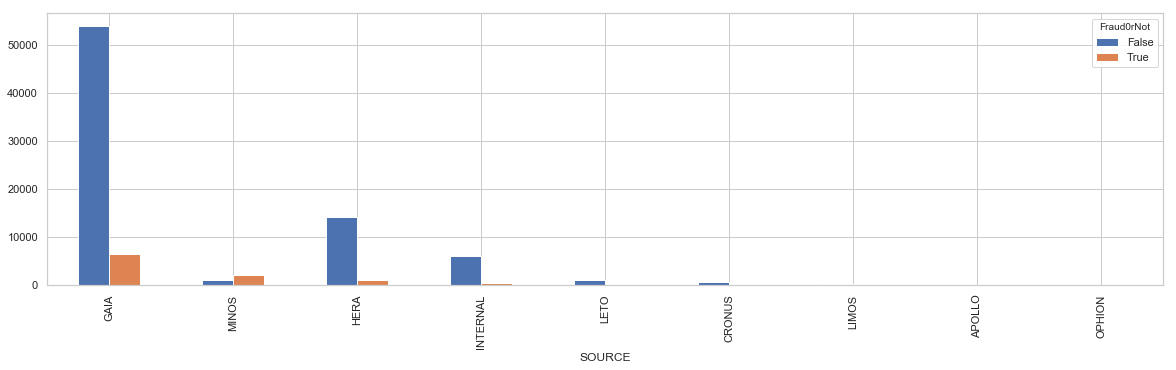

In [345]:
print(pd.crosstab(trainDF.SOURCE,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:20])
pd.crosstab(trainDF.SOURCE, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:20].plot(kind='bar', figsize=(20, 5))

- We can see high Fraud for MINOS Let's check its Lift

In [346]:
impFunctions.calculateLiftDiscrete([trainDF.SOURCE], trainDF.Fraud0rNot,
                                   ['SOURCE']).sort_values(
                                       'lift', ascending=False)

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
7,SOURCE,MINOS,3139,0.036008,2015,1124,0.6419,0.2012,13.81
6,SOURCE,LIMOS,157,0.001801,22,135,0.1401,0.0022,1.26
5,SOURCE,LETO,1085,0.012446,116,969,0.1069,0.0116,0.92
2,SOURCE,GAIA,60338,0.692156,6391,53947,0.1059,0.6381,0.91
1,SOURCE,CRONUS,718,0.008236,75,643,0.1045,0.0075,0.90
0,SOURCE,APOLLO,82,0.000941,6,76,0.0732,0.0006,0.61
3,SOURCE,HERA,15185,0.174192,1032,14153,0.0680,0.1030,0.56
4,SOURCE,INTERNAL,6449,0.073978,359,6090,0.0557,0.0358,0.45
8,SOURCE,OPHION,21,0.000241,0,21,0.0000,0.0000,0.00


- We can see high lift for MINOS and LIMOS Sourced transactions 

## HAS E-MAIL

Fraud0rNot  False  True 
HAS_EMAIL               
1           76765  10016
0             393      0


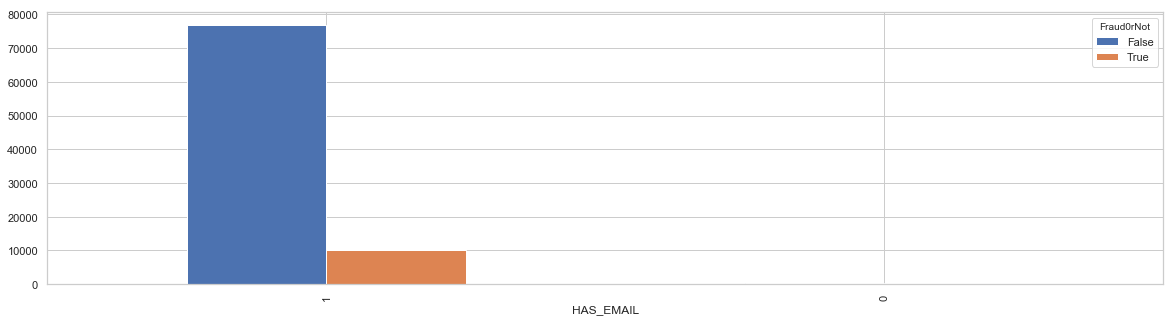

In [347]:
print(pd.crosstab(trainDF.HAS_EMAIL,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:20])
pd.crosstab(trainDF.HAS_EMAIL, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:20].plot(kind='bar', figsize=(20, 5))

- This variable alone has no considerate lift associated to it as almost all the transactions has email

## COUNTRY

Fraud0rNot  False  True 
COUNTRY                 
GB          43071   8874
DE            897    508
PL           3892    340
LT           5338    115
ES           1649    113
RO            990     38
FR           6432     19


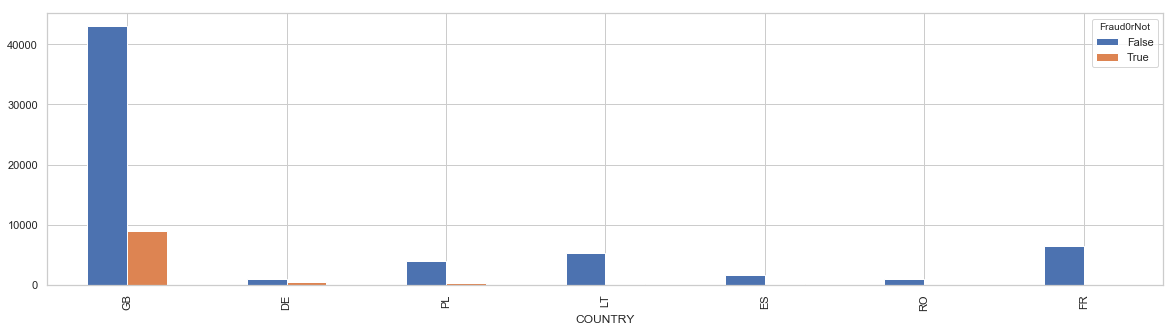

In [350]:
print(pd.crosstab(trainDF.COUNTRY,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:7])
pd.crosstab(trainDF.COUNTRY, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:7].plot(kind='bar', figsize=(20, 5))

In [354]:
impFunctions.calculateLiftDiscrete([
    trainDF.COUNTRY
], trainDF.Fraud0rNot, ['COUNTRY'
                        ]).sort_values(by='lift', ascending=False)[:7]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
6,COUNTRY,DE,1405,0.016117,508,897,0.3616,0.0507,4.36
12,COUNTRY,GB,51945,0.595877,8874,43071,0.1708,0.8860,1.59
28,COUNTRY,PL,4232,0.048547,340,3892,0.0803,0.0339,0.67
9,COUNTRY,ES,1762,0.020212,113,1649,0.0641,0.0113,0.53
30,COUNTRY,RO,1028,0.011793,38,990,0.0370,0.0038,0.30
22,COUNTRY,LT,5453,0.062553,115,5338,0.0211,0.0115,0.17
1,COUNTRY,BE,308,0.003533,4,304,0.0130,0.0004,0.10


- We can see DE has high fraud and thus, lift is very high for this category  

## KYC

Fraud0rNot  False  True 
KYC                     
PASSED      76659   8225
PENDING        12   1439
FAILED        153    352
NONE          334      0


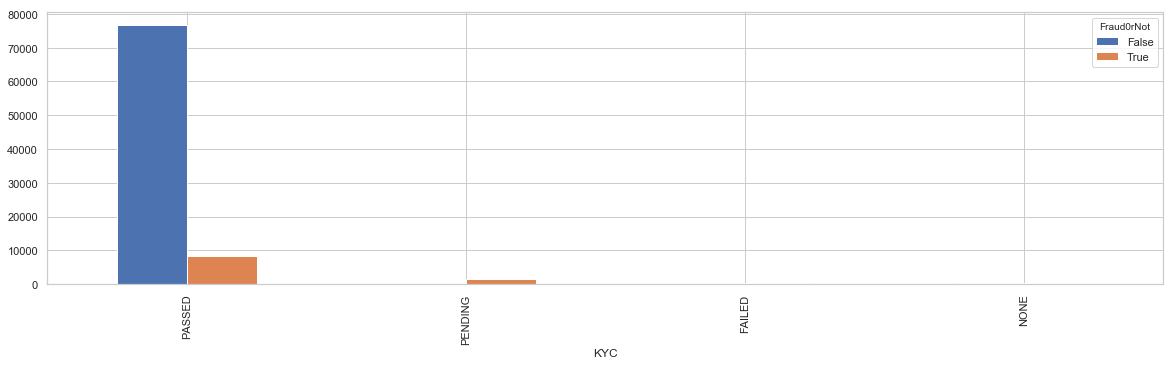

In [353]:
print(pd.crosstab(trainDF.KYC,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:7])
pd.crosstab(trainDF.KYC, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:7].plot(kind='bar', figsize=(20, 5))

In [355]:
impFunctions.calculateLiftDiscrete([
    trainDF.KYC
], trainDF.Fraud0rNot, ['KYC'
                        ]).sort_values(by='lift', ascending=False)[:7]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
3,KYC,PENDING,1451,0.016645,1439,12,0.9917,0.1437,923.77
0,KYC,FAILED,505,0.005793,352,153,0.6970,0.0351,17.72
2,KYC,PASSED,84884,0.973731,8225,76659,0.0969,0.8212,0.83
1,KYC,NONE,334,0.003831,0,334,0.0000,0.0000,0.00


- we see can see most of the KYC pending transactions are ending up as Fraud and same goes for KYC failed transactions

## FAILED SIGN IN ATTEMPTS

Fraud0rNot               False  True 
FAILED_SIGN_IN_ATTEMPTS              
0                        76802   9972
1                          352     38
2                            4      6


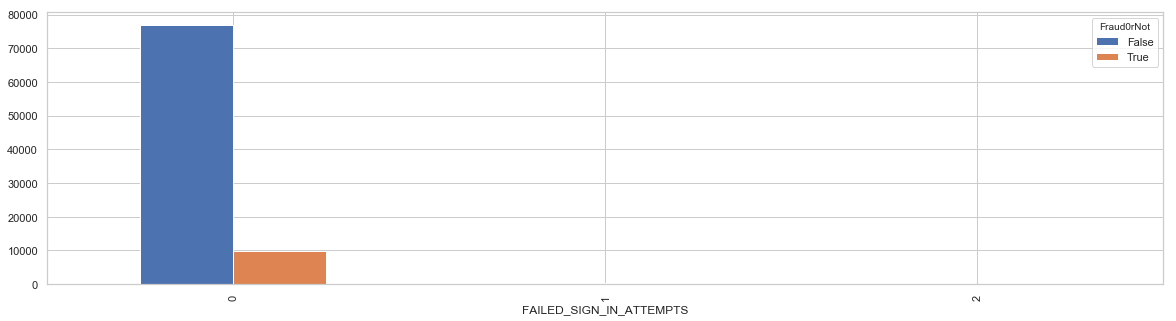

In [357]:
print(pd.crosstab(trainDF.FAILED_SIGN_IN_ATTEMPTS,
                trainDF.Fraud0rNot).sort_values(1, ascending=False)[:7])
pd.crosstab(trainDF.FAILED_SIGN_IN_ATTEMPTS, trainDF.Fraud0rNot).sort_values(
    1, ascending=False)[:7].plot(kind='bar', figsize=(20, 5))

In [358]:
impFunctions.calculateLiftDiscrete([trainDF.FAILED_SIGN_IN_ATTEMPTS], trainDF.Fraud0rNot,
                                   ['FAILED_SIGN_IN_ATTEMPTS']).sort_values('lift',
                                                         ascending=False)[:10]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
2,FAILED_SIGN_IN_ATTEMPTS,2,10,0.000115,6,4,0.6000,0.0006,11.56
0,FAILED_SIGN_IN_ATTEMPTS,0,86774,0.995411,9972,76802,0.1149,0.9956,1.00
1,FAILED_SIGN_IN_ATTEMPTS,1,390,0.004474,38,352,0.0974,0.0038,0.83


## IS_CRYPTO

In [359]:
impFunctions.calculateLiftDiscrete([trainDF.IS_CRYPTO], trainDF.Fraud0rNot,
                                   ['IS_CRYPTO']).sort_values('lift',
                                                         ascending=False)[:20]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
1,IS_CRYPTO,True,14,0.000161,3,11,0.2143,0.0003,2.1
0,IS_CRYPTO,False,87160,0.999839,10013,77147,0.1149,0.9997,1.0


- most of the transactions are in False and very few in True however, is worth keeping in the model as the traffic for CRYPTO currency is 

## CODE || NAME || CODE3 || NUMCODE || PHONECODE || CCY || EXPONENT

In [361]:
trainDF[trainDF.MERCHANT_COUNTRY == '_MISS'].NUMCODE.value_counts()

826.0    15340
250.0     2226
440.0     1967
616.0     1499
372.0     1120
724.0      600
428.0      534
642.0      483
620.0      415
276.0      379
191.0      337
470.0      290
100.0      227
380.0      204
756.0      172
348.0      168
528.0      157
300.0      148
208.0      113
203.0       96
56.0        93
246.0       82
752.0       46
196.0       40
705.0       27
233.0       22
40.0        20
578.0       13
292.0       10
438.0        7
703.0        5
352.0        2
442.0        2
254.0        1
Name: NUMCODE, dtype: int64

- I will use only numCode for Contry encoding as it will capture the required lift.

## Time Based Feilds Analysis 

### Created_Date_x(current transaction) - Created_Date_y(User Created Time)

In [366]:
trainDF['Current_Created_User'] = (trainDF.CREATED_DATE_x-trainDF.CREATED_DATE_y)/np.timedelta64(1,'D')

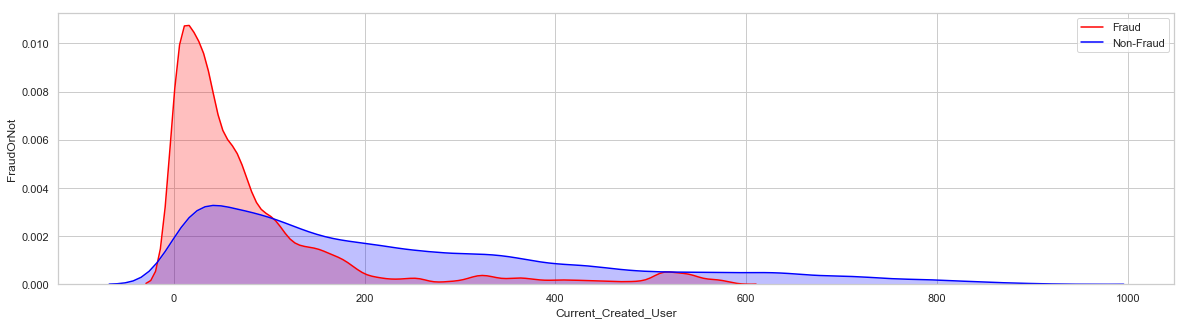

In [367]:
plt.figure(figsize=(20, 5))
g = sns.kdeplot(trainDF["Current_Created_User"][(trainDF["Fraud0rNot"] == True)
                                     & (trainDF["Current_Created_User"].notnull())
                                     ],
                color="Red",
                shade=True)
g = sns.kdeplot(trainDF["Current_Created_User"][(trainDF["Fraud0rNot"] == False)
                                     & (trainDF["Current_Created_User"].notnull())
                                     ],
                ax=g,
                color="Blue",
                shade=True)
g.set_xlabel("Current_Created_User")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

- we can understand that more recently created users are highly suspicious in comparison to old users 

### CREATED_DATE_x(Current Transaction) - TERM_VERSION

In [368]:
trainDF['Current_Term_Version'] = (trainDF.CREATED_DATE_x-trainDF.TERMS_VERSION)/np.timedelta64(1,'D')

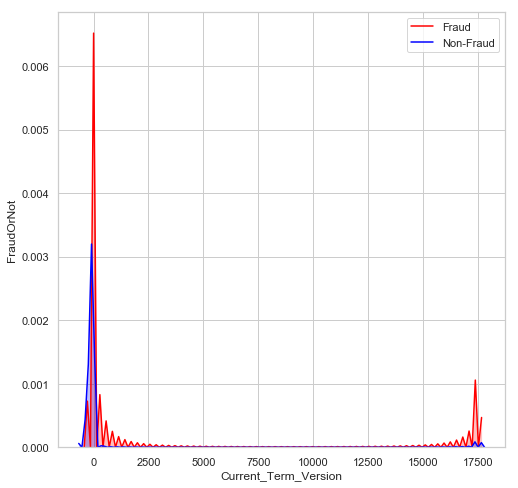

In [369]:
plt.figure(figsize=(8, 8))
g = sns.kdeplot(trainDF["Current_Term_Version"][(trainDF["Fraud0rNot"] == True)
                                     & (trainDF["Current_Term_Version"].notnull())
                                     ],
                color="Red",
                shade=True)
g = sns.kdeplot(trainDF["Current_Term_Version"][(trainDF["Fraud0rNot"] == False)
                                     & (trainDF["Current_Term_Version"].notnull())
                                     ],
                ax=g,
                color="Blue",
                shade=True)
g.set_xlabel("Current_Term_Version")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

- Since, we replaced the missing in the TERM_VERSION with epoch start date thus, the difference is really high resulting in the spike at the tail of the graph

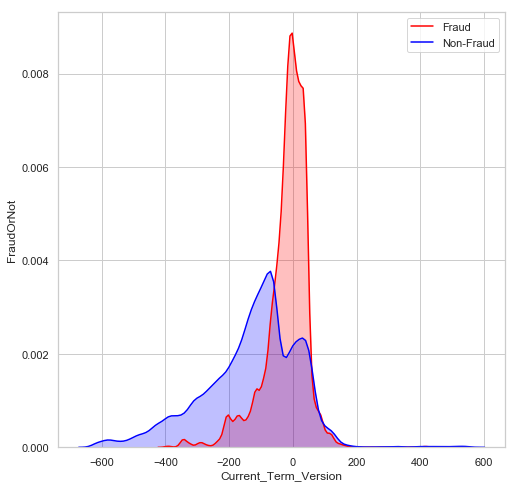

In [372]:
plt.figure(figsize=(8, 8))
g = sns.kdeplot(trainDF["Current_Term_Version"]
                [(trainDF["Fraud0rNot"] == True)
                 & (trainDF["Current_Term_Version"].notnull())
                 & (trainDF["Current_Term_Version"] < 2000)],
                color="Red",
                shade=True)
g = sns.kdeplot(trainDF["Current_Term_Version"]
                [(trainDF["Fraud0rNot"] == False)
                 & (trainDF["Current_Term_Version"].notnull())
                 & (trainDF["Current_Term_Version"] < 2000)],
                ax=g,
                color="Blue",
                shade=True)
g.set_xlabel("Current_Term_Version")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

- We can see serge in Fraud activity for recent TERM VERSION dates as well

In [374]:
impFunctions.calculateLiftDiscrete([trainDF.TERMS_VERSION], trainDF.Fraud0rNot,
                                   ['TERMS_VERSION']).sort_values('lift',
                                                         ascending=False)[:20]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
3,TERMS_VERSION,2018-01-01,1248,0.014316,483,765,0.3870,0.0482,4.86
0,TERMS_VERSION,1970-01-01,2759,0.031649,1046,1713,0.3791,0.1044,4.70
5,TERMS_VERSION,2018-03-20,16577,0.190160,4863,11714,0.2934,0.4855,3.20
2,TERMS_VERSION,2017-02-02,961,0.011024,226,735,0.2352,0.0226,2.37
4,TERMS_VERSION,2018-01-13,1350,0.015486,247,1103,0.1830,0.0247,1.73
6,TERMS_VERSION,2018-05-25,27311,0.313293,3151,24160,0.1154,0.3146,1.00
1,TERMS_VERSION,2017-01-16,161,0.001847,0,161,0.0000,0.0000,0.00
7,TERMS_VERSION,2018-09-20,36807,0.422225,0,36807,0.0000,0.0000,0.00


- if we keep TERM VERSION as a categorical variable it shows more lift

### BIRTH YEAR

In [376]:
impFunctions.calculateLiftDiscrete([trainDF.BIRTH_YEAR], trainDF.Fraud0rNot,
                                   ['BIRTH_YEAR']).sort_values('lift',
                                                         ascending=False)[:5]

,variableName,category,totalTrx,totalTrxPerCat,totalFraud,totalClean,margineFraudGain,detectionRate,lift
0,BIRTH_YEAR,1936,3,0.000034,3,0,1.0000,0.0003,inf
12,BIRTH_YEAR,1959,110,0.001262,99,11,0.9000,0.0099,69.33
8,BIRTH_YEAR,1955,22,0.000252,16,6,0.7273,0.0016,20.54
52,BIRTH_YEAR,1999,406,0.004657,176,230,0.4335,0.0176,5.89
25,BIRTH_YEAR,1972,514,0.005896,195,319,0.3794,0.0195,4.71


- again birth year has high lift

# Feature Engineering 

In [5]:
X_train = pd.DataFrame()
Y_train = pd.Series(np.where(trainDF.Fraud0rNot==False,0,1))

In [6]:
Y_train.value_counts()

0    77158
1    10016
dtype: int64

### User Based Features

#### User Amount(USD) Z-Score

In [7]:
temp1 = pd.DataFrame({
    'USER_ID':
    trainDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'AMOUNT_USD_Mean':
    trainDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    trainDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})
trainDF = pd.merge(trainDF, temp1, on='USER_ID', how='left')

In [8]:
trainDF.AMOUNT_USD_Std.fillna(-9999, inplace=True)
X_train['USER_AMOUNT_Z-Score'] = np.where(
    ((trainDF.AMOUNT_USD_Std == 0.0) | (trainDF.AMOUNT_USD_Std == -9999)),
    -9999,
    ((trainDF.AMOUNT_USD - trainDF.AMOUNT_USD_Mean) / trainDF.AMOUNT_USD_Std))

#### User Amount(USD) + hourOfDay Z-Score

In [9]:
temp2 = pd.DataFrame({
    'USER_ID':
    trainDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'trx_hour_of_day' : trainDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['trx_hour_of_day'],
    'AMOUNT_USD_Mean':
    trainDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    trainDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})

In [10]:
trainDF = pd.merge(trainDF, temp2,  how='left', left_on=['USER_ID','trx_hour_of_day'], right_on = ['USER_ID','trx_hour_of_day'])

In [11]:
trainDF.AMOUNT_USD_Std_y.fillna(-9999, inplace=True)
X_train['USER_AMOUNT_hourOfDay_Z-Score'] = np.where(
    ((trainDF.AMOUNT_USD_Std_y == 0.0) | (trainDF.AMOUNT_USD_Std_y == -9999)),
    -9999,
    ((trainDF.AMOUNT_USD - trainDF.AMOUNT_USD_Mean_y) / trainDF.AMOUNT_USD_Std_y))

#### USer Amount(USD) per day of week Z-Score

In [12]:
temp3 = pd.DataFrame({
    'USER_ID':
    trainDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'trx_day_of_week' : trainDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['trx_day_of_week'],
    'AMOUNT_USD_Mean':
    trainDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    trainDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})
trainDF = pd.merge(trainDF, temp3,  how='left', left_on=['USER_ID','trx_day_of_week'], right_on = ['USER_ID','trx_day_of_week'])

In [13]:
trainDF.AMOUNT_USD_Std.fillna(-9999, inplace=True)
X_train['USER_AMOUNT_dayOfWeek_Z-Score'] = np.where(
    ((trainDF.AMOUNT_USD_Std == 0.0) | (trainDF.AMOUNT_USD_Std == -9999)),
    -9999,
    ((trainDF.AMOUNT_USD - trainDF.AMOUNT_USD_Mean) / trainDF.AMOUNT_USD_Std))

#### User Phone Country Count

In [14]:
X_train['User_PHONE_COUNTRY_Count'] = pd.Series(trainDF.PHONE_COUNTRY.str.count('\|\|')+1)

#### USer Currency Count 

In [15]:
X_train['User_Unique_Currency_Count'] = pd.Series(
    pd.merge(trainDF,
             trainDF.groupby(['USER_ID'])['CURRENCY'].nunique().reset_index(),
             how='left',
             on='USER_ID')['CURRENCY_y'])

In [16]:
del temp1,temp2,temp3

### Transaction Based Features

In [17]:
X_train['AMOUNT_USD'] = trainDF.AMOUNT_USD.copy()
X_train['AMOUNT_USD-AMOUNT'] = pd.Series(trainDF["AMOUNT_USD"] -
                                         trainDF["AMOUNT"])
X_train['AMOUNT_USD_First_Digit'] = pd.Series(pd.to_numeric(trainDF.AMOUNT_USD.apply(lambda x : str(x)[0])))
X_train['AMOUNT_USD_Last_Digit']  = pd.Series(pd.to_numeric(trainDF.AMOUNT_USD.apply(lambda x : str(x)[-1])))

In [18]:
X_train['Currency'] = pd.Series(
    np.where(
        trainDF.CURRENCY == 'GBP', 1,
        np.where(trainDF.CURRENCY == 'EUR', 2,
                 np.where(
                     trainDF.CURRENCY == 'PLN',
                     3,np.where(trainDF.CURRENCY=='USD',4,5)
                 ))))

In [19]:
X_train['MERCHANT_CATEGORY_'] = pd.Series(
    pd.merge(trainDF['MERCHANT_CATEGORY_'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.MERCHANT_CATEGORY_], trainDF.Fraud0rNot,
                 ['MERCHANT_CATEGORY_']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='MERCHANT_CATEGORY_',
             right_on='category',
             how='left')['lift'])

In [20]:
X_train['MERCHANT_COUNTRY'] = pd.Series(
    pd.merge(trainDF['MERCHANT_COUNTRY'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.MERCHANT_COUNTRY], trainDF.Fraud0rNot,
                 ['MERCHANT_COUNTRY']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='MERCHANT_COUNTRY',
             right_on='category',
             how='left')['lift'])

In [21]:
X_train['ENTRY_METHOD'] = pd.Series(
    pd.merge(trainDF['ENTRY_METHOD'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.ENTRY_METHOD], trainDF.Fraud0rNot,
                 ['ENTRY_METHOD']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='ENTRY_METHOD',
             right_on='category',
             how='left')['lift'])

In [22]:
X_train['TYPE'] = pd.Series(
    pd.merge(trainDF['TYPE'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.TYPE], trainDF.Fraud0rNot,
                 ['TYPE']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='TYPE',
             right_on='category',
             how='left')['lift'])

In [23]:
X_train['SOURCE'] = pd.Series(
    pd.merge(trainDF['SOURCE'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.SOURCE], trainDF.Fraud0rNot,
                 ['SOURCE']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='SOURCE',
             right_on='category',
             how='left')['lift'])

In [24]:
X_train['HAS_E-MAIL'] = trainDF.HAS_EMAIL.copy()

In [25]:
X_train['COUNTRY'] = trainDF.NUMCODE.copy()

In [26]:
X_train['KYC'] = pd.Series(
    pd.merge(trainDF['KYC'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.KYC], trainDF.Fraud0rNot,
                 ['KYC']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='KYC',
             right_on='category',
             how='left')['lift'])

In [27]:
X_train['FAILED_SIGN_IN_ATTEMPT'] = trainDF.FAILED_SIGN_IN_ATTEMPTS.copy()

In [28]:
X_train['IS_CRYPTO'] = pd.Series(np.where(trainDF.IS_CRYPTO == False,0,1))

### Time Based Features

In [29]:
X_train['TERMS_VERSION'] = pd.Series(
    pd.merge(trainDF['TERMS_VERSION'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.TERMS_VERSION], trainDF.Fraud0rNot,
                 ['TERMS_VERSION']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='TERMS_VERSION',
             right_on='category',
             how='left')['lift'])

In [30]:
X_train['BIRTH_YEAR'] = trainDF.BIRTH_YEAR.copy()

In [31]:
X_train['Current_Created_User'] = pd.Series(trainDF.CREATED_DATE_x-trainDF.CREATED_DATE_y)/np.timedelta64(1,'D')

In [32]:
X_train['trx_Month'] = trainDF.transaction_Month 

In [33]:
X_train.columns.to_series()[np.isinf(X_train).any()]

MERCHANT_COUNTRY    MERCHANT_COUNTRY
dtype: object

In [34]:
X_train.replace([np.inf, -np.inf], 999,inplace=True)

### Final Check For Features

In [35]:
X_train.shape

(87174, 24)

In [36]:
X_train.head()

,USER_AMOUNT_Z-Score,USER_AMOUNT_hourOfDay_Z-Score,USER_AMOUNT_dayOfWeek_Z-Score,User_PHONE_COUNTRY_Count,User_Unique_Currency_Count,AMOUNT_USD,AMOUNT_USD-AMOUNT,AMOUNT_USD_First_Digit,AMOUNT_USD_Last_Digit,Currency,MERCHANT_CATEGORY_,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,HAS_E-MAIL,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPT,IS_CRYPTO,TERMS_VERSION,BIRTH_YEAR,Current_Created_User,trx_Month
0,-0.290582,-0.908000,-0.639418,1,3,539,54,5,9,2,0.61,0.04,0.58,0.74,0.91,1,372.0,0.83,0,0,4.86,1989,184.197261,1
1,-0.317311,0.848415,-0.409997,1,3,1112,112,1,2,2,0.79,0.00,1.79,0.74,0.91,1,440.0,0.83,0,0,0.00,1984,101.757953,1
2,-0.353462,-0.839168,-0.362639,4,1,1116,230,1,6,1,0.79,0.04,0.58,0.74,0.91,1,826.0,0.83,0,0,4.70,1992,66.322508,1
3,-0.753453,0.707107,-0.529796,4,1,1764,364,1,4,1,1.19,1.20,1.19,1.19,0.61,1,826.0,0.83,0,0,0.00,1990,37.934531,1
4,-0.844444,-0.707107,-0.636336,4,1,1260,260,1,0,1,1.19,1.20,1.19,1.19,0.61,1,826.0,0.83,0,0,0.00,1990,37.937256,1


In [37]:
X_train.isnull().sum()

USER_AMOUNT_Z-Score              0
USER_AMOUNT_hourOfDay_Z-Score    0
USER_AMOUNT_dayOfWeek_Z-Score    0
User_PHONE_COUNTRY_Count         0
User_Unique_Currency_Count       0
AMOUNT_USD                       0
AMOUNT_USD-AMOUNT                0
AMOUNT_USD_First_Digit           0
AMOUNT_USD_Last_Digit            0
Currency                         0
MERCHANT_CATEGORY_               0
MERCHANT_COUNTRY                 0
ENTRY_METHOD                     0
TYPE                             0
SOURCE                           0
HAS_E-MAIL                       0
COUNTRY                          0
KYC                              0
FAILED_SIGN_IN_ATTEMPT           0
IS_CRYPTO                        0
TERMS_VERSION                    0
BIRTH_YEAR                       0
Current_Created_User             0
trx_Month                        0
dtype: int64

In [38]:
X_train.dtypes

USER_AMOUNT_Z-Score              float64
USER_AMOUNT_hourOfDay_Z-Score    float64
USER_AMOUNT_dayOfWeek_Z-Score    float64
User_PHONE_COUNTRY_Count           int64
User_Unique_Currency_Count         int64
AMOUNT_USD                         int64
AMOUNT_USD-AMOUNT                  int64
AMOUNT_USD_First_Digit             int64
AMOUNT_USD_Last_Digit              int64
Currency                           int64
MERCHANT_CATEGORY_               float64
MERCHANT_COUNTRY                 float64
ENTRY_METHOD                     float64
TYPE                             float64
SOURCE                           float64
HAS_E-MAIL                         int64
COUNTRY                          float64
KYC                              float64
FAILED_SIGN_IN_ATTEMPT             int64
IS_CRYPTO                          int64
TERMS_VERSION                    float64
BIRTH_YEAR                         int64
Current_Created_User             float64
trx_Month                          int64
dtype: object

# Feature Selection 

## Correlation 

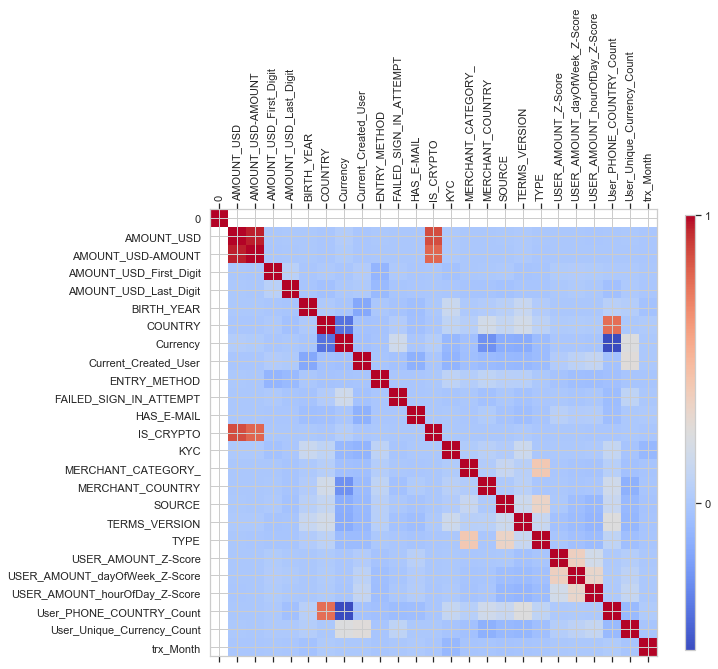

In [483]:
impFunctions.plot_corr_(pd.concat([X_train,Y_train]))

In [484]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['AMOUNT_USD-AMOUNT']

# Model Building 

## Loading State-of-the-art Algorithms

In [16]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Best Model Selection based on Cross-Val

In [492]:
kfold = StratifiedKFold(n_splits=5)
random_state = 2
classifiers = []

classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(lgb.LGBMClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "roc_auc", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

   CrossValMeans  CrossValerrors           Algorithm
0       0.965750        0.034531        RandomForest
1       0.908066        0.053231  LogisticRegression
2       0.983194        0.014205             XGBoost
3       0.991427        0.005906            LightGBM


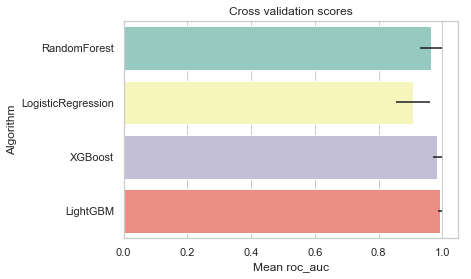

In [494]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["RandomForest","LogisticRegression","XGBoost","LightGBM"]})
print(cv_res)
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean roc_auc")
g = g.set_title("Cross validation scores")

- The above graph show remarkable result, But isn't it too good to be true
- The results are flawed due to the data leaking to eLaborate further, as we are using cross-validation thus, data is being randomly split amidst the 5 different chunks. Resulting in model training on some fraud user and then being tested on same fraud users thus, resulting in such good results
- Nevertheless, I would choose LightGBM as the error is very less and Logistic Regression for further Analysis 

# Prepare Validation DataSet

- Due to problem we faced with default cross validation we are going to use Validation dataframe to evaluate our model

### Load Validation Data 

In [39]:
validationDF = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/validationDF.csv")
validationDF['CREATED_DATE_x'] = pd.to_datetime(validationDF.CREATED_DATE_x)
validationDF['CREATED_DATE_y'] = pd.to_datetime(validationDF.CREATED_DATE_y)
validationDF['TERMS_VERSION']  = pd.to_datetime(validationDF.TERMS_VERSION)

In [40]:
validationDF['trx_hour_of_day'] = pd.Series(validationDF.CREATED_DATE_x.dt.hour)
validationDF['trx_day_of_week'] = pd.Series(validationDF.CREATED_DATE_x.dt.dayofweek)

### Transform Validation Data 

In [41]:
X_val = pd.DataFrame()
Y_val = pd.Series(np.where(validationDF.Fraud0rNot==False,0,1))

In [42]:
######################################## USER Based Features ########################################
temp1 = pd.DataFrame({
    'USER_ID':
    validationDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'AMOUNT_USD_Mean':
    validationDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    validationDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})
validationDF = pd.merge(validationDF, temp1, on='USER_ID', how='left')
validationDF.AMOUNT_USD_Std.fillna(-9999, inplace=True)
X_val['USER_AMOUNT_Z-Score'] = np.where(
    ((validationDF.AMOUNT_USD_Std == 0.0) | (validationDF.AMOUNT_USD_Std == -9999)),
    -9999,
    ((validationDF.AMOUNT_USD - validationDF.AMOUNT_USD_Mean) / validationDF.AMOUNT_USD_Std))
temp2 = pd.DataFrame({
    'USER_ID':
    validationDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'trx_hour_of_day' : validationDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['trx_hour_of_day'],
    'AMOUNT_USD_Mean':
    validationDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    validationDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})

validationDF = pd.merge(validationDF, temp2,  how='left', left_on=['USER_ID','trx_hour_of_day'], right_on = ['USER_ID','trx_hour_of_day'])
validationDF.AMOUNT_USD_Std_y.fillna(-9999, inplace=True)
X_val['USER_AMOUNT_hourOfDay_Z-Score'] = np.where(
    ((validationDF.AMOUNT_USD_Std_y == 0.0) | (validationDF.AMOUNT_USD_Std_y == -9999)),
    -9999,
    ((validationDF.AMOUNT_USD - validationDF.AMOUNT_USD_Mean_y) / validationDF.AMOUNT_USD_Std_y))

temp3 = pd.DataFrame({
    'USER_ID':
    validationDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'trx_day_of_week' : validationDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['trx_day_of_week'],
    'AMOUNT_USD_Mean':
    validationDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    validationDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})
validationDF = pd.merge(validationDF, temp3,  how='left', left_on=['USER_ID','trx_day_of_week'], right_on = ['USER_ID','trx_day_of_week'])

validationDF.AMOUNT_USD_Std.fillna(-9999, inplace=True)
X_val['USER_AMOUNT_dayOfWeek_Z-Score'] = np.where(
    ((validationDF.AMOUNT_USD_Std == 0.0) | (validationDF.AMOUNT_USD_Std == -9999)),
    -9999,
    ((validationDF.AMOUNT_USD - validationDF.AMOUNT_USD_Mean) / validationDF.AMOUNT_USD_Std))

X_val['User_PHONE_COUNTRY_Count'] = pd.Series(validationDF.PHONE_COUNTRY.str.count('\|\|')+1)

X_val['User_Unique_Currency_Count'] = pd.Series(
    pd.merge(validationDF,
             validationDF.groupby(['USER_ID'])['CURRENCY'].nunique().reset_index(),
             how='left',
             on='USER_ID')['CURRENCY_y'])

del temp1,temp2,temp3
##############################################################################################

In [44]:
X_val['AMOUNT_USD'] = validationDF.AMOUNT_USD.copy()
X_val['AMOUNT_USD-AMOUNT'] = pd.Series(validationDF["AMOUNT_USD"] -
                                         validationDF["AMOUNT"])
X_val['AMOUNT_USD_First_Digit'] = pd.Series(pd.to_numeric(validationDF.AMOUNT_USD.apply(lambda x : str(x)[0])))
X_val['AMOUNT_USD_Last_Digit']  = pd.Series(pd.to_numeric(validationDF.AMOUNT_USD.apply(lambda x : str(x)[-1])))
X_val['Currency'] = pd.Series(
    np.where(
        validationDF.CURRENCY == 'GBP', 1,
        np.where(validationDF.CURRENCY == 'EUR', 2,
                 np.where(
                     validationDF.CURRENCY == 'PLN',
                     3,np.where(validationDF.CURRENCY=='USD',4,5)
                 ))))
 
X_val['MERCHANT_CATEGORY_'] = pd.Series(
    pd.merge(validationDF['MERCHANT_CATEGORY_'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.MERCHANT_CATEGORY_], trainDF.Fraud0rNot,
                 ['MERCHANT_CATEGORY_']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='MERCHANT_CATEGORY_',
             right_on='category',
             how='left')['lift'])

X_val['MERCHANT_COUNTRY'] = pd.Series(
    pd.merge(validationDF['MERCHANT_COUNTRY'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.MERCHANT_COUNTRY], trainDF.Fraud0rNot,
                 ['MERCHANT_COUNTRY']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='MERCHANT_COUNTRY',
             right_on='category',
             how='left')['lift'])

X_val['ENTRY_METHOD'] = pd.Series(
    pd.merge(validationDF['ENTRY_METHOD'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.ENTRY_METHOD], trainDF.Fraud0rNot,
                 ['ENTRY_METHOD']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='ENTRY_METHOD',
             right_on='category',
             how='left')['lift'])

X_val['TYPE'] = pd.Series(
    pd.merge(validationDF['TYPE'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.TYPE], trainDF.Fraud0rNot,
                 ['TYPE']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='TYPE',
             right_on='category',
             how='left')['lift'])
 
X_val['SOURCE'] = pd.Series(
    pd.merge(validationDF['SOURCE'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.SOURCE], trainDF.Fraud0rNot,
                 ['SOURCE']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='SOURCE',
             right_on='category',
             how='left')['lift'])
 
X_val['HAS_E-MAIL'] = validationDF.HAS_EMAIL.copy()
X_val['COUNTRY'] = validationDF.NUMCODE.copy()
X_val['KYC'] = pd.Series(
    pd.merge(validationDF['KYC'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.KYC], trainDF.Fraud0rNot,
                 ['KYC']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='KYC',
             right_on='category',
             how='left')['lift'])
 
 
X_val['FAILED_SIGN_IN_ATTEMPT'] = validationDF.FAILED_SIGN_IN_ATTEMPTS.copy()
X_val['IS_CRYPTO'] = pd.Series(np.where(validationDF.IS_CRYPTO == False,0,1))
X_val['TERMS_VERSION'] = pd.Series(
    pd.merge(validationDF['TERMS_VERSION'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.TERMS_VERSION], trainDF.Fraud0rNot,
                 ['TERMS_VERSION']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='TERMS_VERSION',
             right_on='category',
             how='left')['lift'])

X_val['BIRTH_YEAR'] = validationDF.BIRTH_YEAR.copy()
X_val['Current_Created_User'] = pd.Series(validationDF.CREATED_DATE_x-validationDF.CREATED_DATE_y)/np.timedelta64(1,'D')
X_val['trx_Month'] = validationDF.transaction_Month 



In [45]:
X_val.isnull().sum()

USER_AMOUNT_Z-Score               0
USER_AMOUNT_hourOfDay_Z-Score     0
USER_AMOUNT_dayOfWeek_Z-Score     0
User_PHONE_COUNTRY_Count          0
User_Unique_Currency_Count        0
AMOUNT_USD                        0
AMOUNT_USD-AMOUNT                 0
AMOUNT_USD_First_Digit            0
AMOUNT_USD_Last_Digit             0
Currency                          0
MERCHANT_CATEGORY_                7
MERCHANT_COUNTRY                 20
ENTRY_METHOD                      0
TYPE                              0
SOURCE                            0
HAS_E-MAIL                        0
COUNTRY                           0
KYC                               0
FAILED_SIGN_IN_ATTEMPT            0
IS_CRYPTO                         0
TERMS_VERSION                     0
BIRTH_YEAR                        0
Current_Created_User              0
trx_Month                         0
dtype: int64

In [46]:
X_val.shape

(22400, 24)

In [47]:
X_val.head()

,USER_AMOUNT_Z-Score,USER_AMOUNT_hourOfDay_Z-Score,USER_AMOUNT_dayOfWeek_Z-Score,User_PHONE_COUNTRY_Count,User_Unique_Currency_Count,AMOUNT_USD,AMOUNT_USD-AMOUNT,AMOUNT_USD_First_Digit,AMOUNT_USD_Last_Digit,Currency,MERCHANT_CATEGORY_,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,HAS_E-MAIL,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPT,IS_CRYPTO,TERMS_VERSION,BIRTH_YEAR,Current_Created_User,trx_Month
0,-0.276832,-0.334535,-0.247465,4,5,2160,446,2,0,1,2.75,0.75,0.88,2.88,0.91,1,826.0,0.83,0,0,1.0,1994,135.151265,1
1,-0.247963,-0.307971,-0.211439,4,5,2506,518,2,6,1,0.79,0.75,0.88,0.74,0.91,1,826.0,0.83,0,0,1.0,1994,135.177748,1
2,-0.724527,-0.696914,-0.948743,4,3,260,53,2,0,1,0.79,NaN,0.58,0.74,0.91,1,826.0,0.83,0,0,0.0,1989,157.122346,1
3,0.594757,2.220882,0.840180,4,5,12606,2606,1,6,1,1.19,1.20,1.19,1.19,0.56,1,826.0,0.83,0,0,1.0,1994,135.702500,1
4,-0.350257,-0.520794,-0.339091,4,5,1280,264,1,0,1,0.45,0.75,0.88,0.74,0.91,1,826.0,0.83,0,0,1.0,1994,135.733862,1


In [48]:
X_val.fillna(-9999,inplace=True)

In [49]:
X_val.columns.to_series()[np.isinf(X_val).any()]

Series([], dtype: object)

In [ ]:
X_val.replace([np.inf, -np.inf], 999,inplace=True)

# Hyper Parameter Tuning

- Due to the hardware limitation on my laptop i had to train the model on Google Co-lab. A separate note-book is provided for that which contains the code.
- However, I tried out some default hyper parameter for the algorithm and their respective result on the validation dataset

### Light-GBM

In [524]:
lgbmmdl = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=0.7, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
lgbmmdl.fit(X_train,Y_train)
Pred_train=lgbmmdl.predict(X_train)
Pred_val=lgbmmdl.predict(X_val)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print(" Train Recall Score := ",metrics.recall_score(Y_train,Pred_train))
print(" val Recall Score := ",metrics.recall_score(Y_val,Pred_val))
print(" Train Precision Score := ",metrics.precision_score(Y_train,Pred_train))
print(" val Precision Score := ",metrics.precision_score(Y_val,Pred_val))
print(" Train AUC-ROC Score := ",metrics.roc_auc_score(Y_train,Pred_train))
print(" val AUC-ROC Score := ",metrics.roc_auc_score(Y_val,Pred_val))
print(" Train F1 Score := ",metrics.f1_score(Y_train,Pred_train))
print(" val F1 Score := ",metrics.f1_score(Y_val,Pred_val))
#evaluation(Confusion Metrix)
print("Train Confusion Matrix:\n",metrics.confusion_matrix(Y_train,Pred_train))
print("val Confusion Matrix:\n",metrics.confusion_matrix(Y_val,Pred_val))

 Train Recall Score :=  0.9762380191693291
 val Recall Score :=  0.6891820580474934
 Train Precision Score :=  0.9866801210898083
 val Precision Score :=  0.7755344418052257
 Train AUC-ROC Score :=  0.9872636219385358
 val AUC-ROC Score :=  0.8353737649418155
 Train F1 Score :=  0.9814312957944394
 val F1 Score :=  0.7298127968706343
Train Confusion Matrix:
 [[77026   132]
 [  238  9778]]
val Confusion Matrix:
 [[20127   378]
 [  589  1306]]


In [525]:
(X_val[(Pred_val == 1)&(Y_val == 1)]['AMOUNT_USD'].sum()/X_val[Y_val == 1]['AMOUNT_USD'].sum())*100

76.91495311429023

- As we can see that model is performing quite good on the validation dataset with following evaluation values:
    1. Recall    := 69% of the total fraud transactions are being caught which comprises of 77% of the value detection i.e. Amount associated to fraud transaction
    2. Precision := 76% of the predicted frauds are correctly identified thus, having low False Positives 
    3. AUC-ROC   := 84% of the area is covered.
    4. F1-Score  := 73% which shows stable model 

### Logistic Regression

In [520]:
lr  = LogisticRegression(C=10, class_weight={1:0.7, 0:0.3}, n_jobs=-1, penalty='l1',random_state=2)
lr.fit(X_train,Y_train)
Pred_train=lr.predict(X_train)
Pred_val=lr.predict(X_val)

#evaluation(Accuracy)
print(" Train Recall Score := ",metrics.recall_score(Y_train,Pred_train))
print(" val Recall Score := ",metrics.recall_score(Y_val,Pred_val))
print(" Train Precision Score := ",metrics.precision_score(Y_train,Pred_train))
print(" val Precision Score := ",metrics.precision_score(Y_val,Pred_val))
print(" Train AUC-ROC Score := ",metrics.roc_auc_score(Y_train,Pred_train))
print(" val AUC-ROC Score := ",metrics.roc_auc_score(Y_val,Pred_val))
print(" Train F1 Score := ",metrics.f1_score(Y_train,Pred_train))
print(" val F1 Score := ",metrics.f1_score(Y_val,Pred_val))
#evaluation(Confusion Metrix)
print("Train Confusion Matrix:\n",metrics.confusion_matrix(Y_train,Pred_train))
print("val Confusion Matrix:\n",metrics.confusion_matrix(Y_val,Pred_val))

 Train Recall Score :=  0.7311301916932907
 val Recall Score :=  0.7509234828496042
 Train Precision Score :=  0.6653643467199709
 val Precision Score :=  0.605531914893617
 Train AUC-ROC Score :=  0.841698484477766
 val AUC-ROC Score :=  0.8528574985572088
 Train F1 Score :=  0.6966986966035582
 val F1 Score :=  0.6704358068315666
Train Confusion Matrix:
 [[73475  3683]
 [ 2693  7323]]
val Confusion Matrix:
 [[19578   927]
 [  472  1423]]


In [523]:
(X_val[(Pred_val == 1)&(Y_val == 1)]['AMOUNT_USD'].sum()/X_val[Y_val == 1]['AMOUNT_USD'].sum())*100

78.83893178301264

- As we can see Logistic Regression is better where L-GBM is lacking let's check the stats as follows:
    1. Recall    := 75% of the fraud transaction are being caught with 79% of the value detection rate
    2. Precision := on the lower side with only 60% of the transactions being correctly identified 
    3. AUC-ROC   := 85% of the area is being covered
    4. F1-Score  := 67% of F1 score 

In [127]:
from sklearn import metrics

#### Caution : Run below only if you have created X_test from the below sections 

In [147]:
### Output of the above Code ####
72.73068446072784

72.73068446072784

### Ensemble LR & LGBM

In [547]:
votingCPre = VotingClassifier(estimators=[('lgbm', lgbmmdl),
                                          ('lr',lr)
                                         ], voting='soft', n_jobs=4)

votingCPre = votingCPre.fit(X_train,Y_train)
Pred_train=votingCPre.predict(X_train)
Pred_val=votingCPre.predict(X_val)
print(" Train Recall Score := ",metrics.recall_score(Y_train,Pred_train))
print(" val Recall Score := ",metrics.recall_score(Y_val,Pred_val))
print(" Train Precision Score := ",metrics.precision_score(Y_train,Pred_train))
print(" val Precision Score := ",metrics.precision_score(Y_val,Pred_val))
print(" Train AUC-ROC Score := ",metrics.roc_auc_score(Y_train,Pred_train))
print(" val AUC-ROC Score := ",metrics.roc_auc_score(Y_val,Pred_val))
print(" Train F1 Score := ",metrics.f1_score(Y_train,Pred_train))
print(" val F1 Score := ",metrics.f1_score(Y_val,Pred_val))
#evaluation(Confusion Metrix)
print("Train Confusion Matrix:\n",metrics.confusion_matrix(Y_train,Pred_train))
print("val Confusion Matrix:\n",metrics.confusion_matrix(Y_val,Pred_val))

 Train Recall Score :=  0.9479832268370607
 val Recall Score :=  0.7224274406332454
 Train Precision Score :=  0.960351977343987
 val Precision Score :=  0.7316942811330839
 Train AUC-ROC Score :=  0.9714513713179057
 val AUC-ROC Score :=  0.8489728034670738
 Train F1 Score :=  0.954127518464553
 val F1 Score :=  0.7270313329792883
Train Confusion Matrix:
 [[76766   392]
 [  521  9495]]
val Confusion Matrix:
 [[20003   502]
 [  526  1369]]


In [548]:
(X_val[(Pred_val == 1)&(Y_val == 1)]['AMOUNT_USD'].sum()/X_val[Y_val == 1]['AMOUNT_USD'].sum())*100

77.6673624917982

- Since both the models are capturing some aspect of the evaluation better I though let's create an ensemble model which will complement each other and boost the performance. Let's check its score as follows :
    1. Recall    := As expected the combined model has boost in recall i.e. 72% of the frauds are being caught which consist of 78% of the value associated to it. 
    2. Precision := 73% of the frauds are correctly identified 
    3. AUC-ROC   := 85% of the area is being covered
    4. F1-Score  := 73% which is stable model 
- Thus, we can conclude that ensemble model would be better stable

# Model Selection 

- based on the hyperparameter tunning we got the below models

### Light-GBM model 

In [135]:
lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
               importance_type='split', learning_rate=0.05, max_bin=512,
               max_depth=7, min_child_samples=5, min_child_weight=1,
               min_split_gain=0.5, n_estimators=100, n_jobs=4, num_leaves=16,
               objective='binary', random_state=501, reg_alpha=1,
               reg_lambda=1.2, scale_pos_weight=1, silent=True, subsample=0.7,
               subsample_for_bin=200, subsample_freq=1)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.05, max_bin=512,
        max_depth=7, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=4, num_leaves=16,
        objective='binary', random_state=501, reg_alpha=1, reg_lambda=1.2,
        scale_pos_weight=1, silent=True, subsample=0.7,
        subsample_for_bin=200, subsample_freq=1)

In [9]:
lgbmmdl = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
               importance_type='split', learning_rate=0.05, max_bin=512,
               max_depth=7, min_child_samples=5, min_child_weight=1,
               min_split_gain=0.5, n_estimators=100, n_jobs=4, num_leaves=16,
               objective='binary', random_state=501, reg_alpha=1,
               reg_lambda=1.2, scale_pos_weight=1, silent=True, subsample=0.7,
               subsample_for_bin=200, subsample_freq=1)

In [10]:
lgbmmdl = lgbmmdl.fit(X_train,Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.05, max_bin=512,
        max_depth=7, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=4, num_leaves=16,
        objective='binary', random_state=501, reg_alpha=1, reg_lambda=1.2,
        scale_pos_weight=1, silent=True, subsample=0.7,
        subsample_for_bin=200, subsample_freq=1)

#### Learning Cure for Light GBM

'00:00:12'

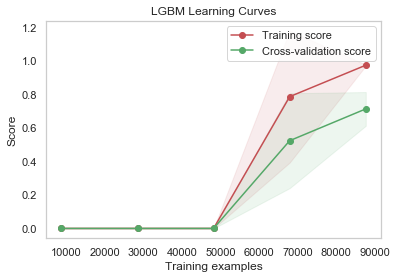

In [585]:
start_time = time.time()
g = impFunctions.plot_learning_curve(lgbmmdl,"LGBM Learning Curves",X_train,Y_train)
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

- Shows LGBM is fitting well and given actually more data will certainly show better results.

### Logistic Regression

In [43]:
lr = LogisticRegression(C=10, class_weight={1: 0.7, 0: 0.3}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=2,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [44]:
lr = lr.fit(X_train,Y_train)

### Ensemble Model 

In [45]:
votingCPre = VotingClassifier(estimators=[('lgbm', lgbmmdl),
                                          ('lr',lr)
                                         ], voting='soft', n_jobs=4)

votingCPre = votingCPre.fit(X_train,Y_train)

#### Feature Importance 

Text(0.5, 1.0, 'Feature importance')

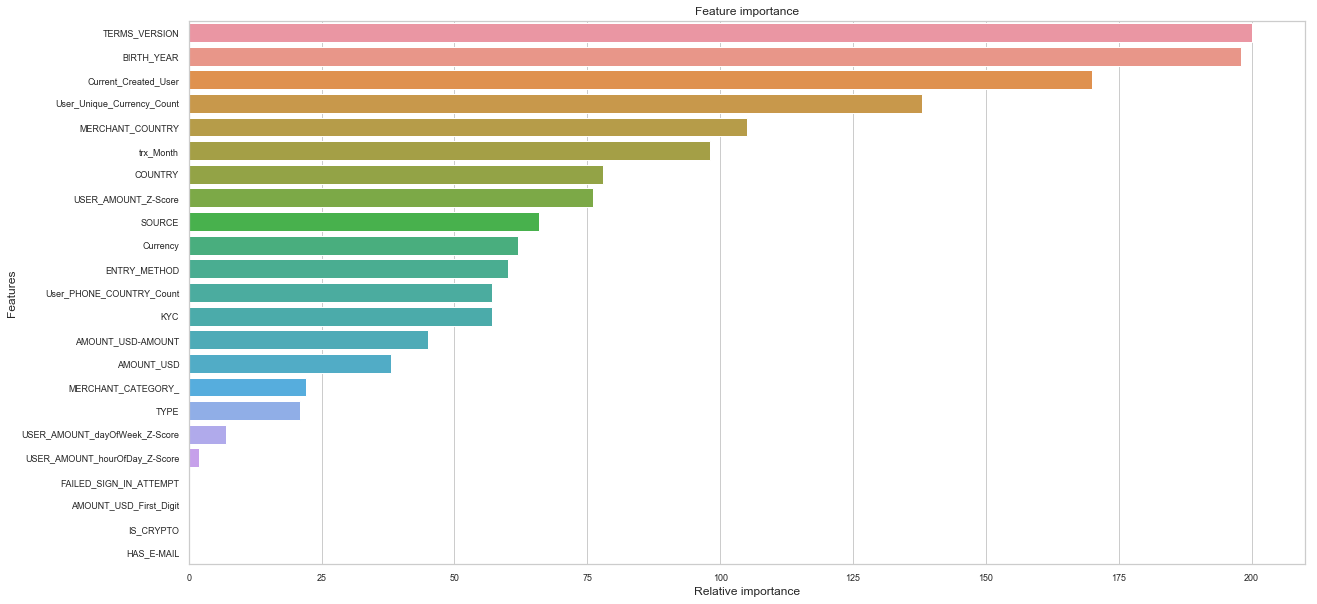

In [143]:
indices = np.argsort(lgbmmdl.feature_importances_)[::-1][:len(X_train.columns.tolist())-1]
plt.figure(figsize=(20,10))
g = sns.barplot(y=X_train.columns[indices][:X_train.shape[1]],x = lgbmmdl.feature_importances_[indices][:X_train.shape[1]] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")

-  We can observe that the top features are Time based  

# Model Test on OOT sample Data 

In [76]:
X_train = X_train.append(X_val)
Y_train = Y_train.append(Y_val)

In [77]:
X_train.shape

(109574, 24)

In [78]:
Y_train.value_counts(normalize=True)*100

0    89.129721
1    10.870279
dtype: float64

In [79]:
testDF = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/testDF.csv")
testDF['CREATED_DATE_x'] = pd.to_datetime(testDF.CREATED_DATE_x)
testDF['CREATED_DATE_y'] = pd.to_datetime(testDF.CREATED_DATE_y)
testDF['TERMS_VERSION']  = pd.to_datetime(testDF.TERMS_VERSION)
testDF['trx_hour_of_day'] = pd.Series(testDF.CREATED_DATE_x.dt.hour)
testDF['trx_day_of_week'] = pd.Series(testDF.CREATED_DATE_x.dt.dayofweek)
###########################################################################################
X_test = pd.DataFrame()
Y_test = pd.Series(np.where(testDF.Fraud0rNot==False,0,1))
######################################## USER based Features ##############################
temp1 = pd.DataFrame({
    'USER_ID':
    testDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'AMOUNT_USD_Mean':
    testDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    testDF.groupby('USER_ID').agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})
testDF = pd.merge(testDF, temp1, on='USER_ID', how='left')
testDF.AMOUNT_USD_Std.fillna(-9999, inplace=True)
X_test['USER_AMOUNT_Z-Score'] = np.where(
    ((testDF.AMOUNT_USD_Std == 0.0) | (testDF.AMOUNT_USD_Std == -9999)),
    -9999,
    ((testDF.AMOUNT_USD - testDF.AMOUNT_USD_Mean) / testDF.AMOUNT_USD_Std))
temp2 = pd.DataFrame({
    'USER_ID':
    testDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'trx_hour_of_day' : testDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['trx_hour_of_day'],
    'AMOUNT_USD_Mean':
    testDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    testDF.groupby(['USER_ID','trx_hour_of_day']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})

testDF = pd.merge(testDF, temp2,  how='left', left_on=['USER_ID','trx_hour_of_day'], right_on = ['USER_ID','trx_hour_of_day'])
testDF.AMOUNT_USD_Std_y.fillna(-9999, inplace=True)
X_test['USER_AMOUNT_hourOfDay_Z-Score'] = np.where(
    ((testDF.AMOUNT_USD_Std_y == 0.0) | (testDF.AMOUNT_USD_Std_y == -9999)),
    -9999,
    ((testDF.AMOUNT_USD - testDF.AMOUNT_USD_Mean_y) / testDF.AMOUNT_USD_Std_y))

temp3 = pd.DataFrame({
    'USER_ID':
    testDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['USER_ID'],
    'trx_day_of_week' : testDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index()['trx_day_of_week'],
    'AMOUNT_USD_Mean':
    testDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['mean'],
    'AMOUNT_USD_Std':
    testDF.groupby(['USER_ID','trx_day_of_week']).agg({
        'AMOUNT_USD': ['mean', np.std]
    }).reset_index().AMOUNT_USD['std']
})
testDF = pd.merge(testDF, temp3,  how='left', left_on=['USER_ID','trx_day_of_week'], right_on = ['USER_ID','trx_day_of_week'])

testDF.AMOUNT_USD_Std.fillna(-9999, inplace=True)
X_test['USER_AMOUNT_dayOfWeek_Z-Score'] = np.where(
    ((testDF.AMOUNT_USD_Std == 0.0) | (testDF.AMOUNT_USD_Std == -9999)),
    -9999,
    ((testDF.AMOUNT_USD - testDF.AMOUNT_USD_Mean) / testDF.AMOUNT_USD_Std))

X_test['User_PHONE_COUNTRY_Count'] = pd.Series(testDF.PHONE_COUNTRY.str.count('\|\|')+1)

X_test['User_Unique_Currency_Count'] = pd.Series(
    pd.merge(testDF,
             testDF.groupby(['USER_ID'])['CURRENCY'].nunique().reset_index(),
             how='left',
             on='USER_ID')['CURRENCY_y'])

del temp1,temp2,temp3
##############################################################################################



X_test['AMOUNT_USD'] = testDF.AMOUNT_USD.copy()
X_test['AMOUNT_USD-AMOUNT'] = pd.Series(testDF["AMOUNT_USD"] -
                                         testDF["AMOUNT"])
X_test['AMOUNT_USD_First_Digit'] = pd.Series(pd.to_numeric(testDF.AMOUNT_USD.apply(lambda x : str(x)[0])))
X_test['AMOUNT_USD_Last_Digit']  = pd.Series(pd.to_numeric(testDF.AMOUNT_USD.apply(lambda x : str(x)[-1])))
X_test['Currency'] = pd.Series(
    np.where(
        testDF.CURRENCY == 'GBP', 1,
        np.where(testDF.CURRENCY == 'EUR', 2,
                 np.where(
                     testDF.CURRENCY == 'PLN',
                     3,np.where(testDF.CURRENCY=='USD',4,5)
                 ))))

X_test['MERCHANT_CATEGORY_'] = pd.Series(
    pd.merge(testDF['MERCHANT_CATEGORY_'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.MERCHANT_CATEGORY_], trainDF.Fraud0rNot,
                 ['MERCHANT_CATEGORY_']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='MERCHANT_CATEGORY_',
             right_on='category',
             how='left')['lift'])

X_test['MERCHANT_COUNTRY'] = pd.Series(
    pd.merge(testDF['MERCHANT_COUNTRY'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.MERCHANT_COUNTRY], trainDF.Fraud0rNot,
                 ['MERCHANT_COUNTRY']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='MERCHANT_COUNTRY',
             right_on='category',
             how='left')['lift'])

X_test['ENTRY_METHOD'] = pd.Series(
    pd.merge(testDF['ENTRY_METHOD'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.ENTRY_METHOD], trainDF.Fraud0rNot,
                 ['ENTRY_METHOD']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='ENTRY_METHOD',
             right_on='category',
             how='left')['lift'])

X_test['TYPE'] = pd.Series(
    pd.merge(testDF['TYPE'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.TYPE], trainDF.Fraud0rNot,
                 ['TYPE']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='TYPE',
             right_on='category',
             how='left')['lift'])
 
X_test['SOURCE'] = pd.Series(
    pd.merge(testDF['SOURCE'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.SOURCE], trainDF.Fraud0rNot,
                 ['SOURCE']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='SOURCE',
             right_on='category',
             how='left')['lift'])
 
X_test['HAS_E-MAIL'] = testDF.HAS_EMAIL.copy()
X_test['COUNTRY'] = testDF.NUMCODE.copy()
X_test['KYC'] = pd.Series(
    pd.merge(testDF['KYC'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.KYC], trainDF.Fraud0rNot,
                 ['KYC']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='KYC',
             right_on='category',
             how='left')['lift'])

X_test['FAILED_SIGN_IN_ATTEMPT'] = testDF.FAILED_SIGN_IN_ATTEMPTS.copy()
X_test['IS_CRYPTO'] = pd.Series(np.where(testDF.IS_CRYPTO == False,0,1))
X_test['TERMS_VERSION'] = pd.Series(
    pd.merge(testDF['TERMS_VERSION'],
             impFunctions.calculateLiftDiscrete(
                 [trainDF.TERMS_VERSION], trainDF.Fraud0rNot,
                 ['TERMS_VERSION']).sort_values(
                     'lift', ascending=False)[['category', 'lift']],
             left_on='TERMS_VERSION',
             right_on='category',
             how='left')['lift'])

X_test['BIRTH_YEAR'] = testDF.BIRTH_YEAR.copy()
X_test['Current_Created_User'] = pd.Series(testDF.CREATED_DATE_x-testDF.CREATED_DATE_y)/np.timedelta64(1,'D')
X_test['trx_Month'] = testDF.transaction_Month 



In [80]:
X_test.isnull().sum()

USER_AMOUNT_Z-Score               0
USER_AMOUNT_hourOfDay_Z-Score     0
USER_AMOUNT_dayOfWeek_Z-Score     0
User_PHONE_COUNTRY_Count          0
User_Unique_Currency_Count        0
AMOUNT_USD                        0
AMOUNT_USD-AMOUNT                 0
AMOUNT_USD_First_Digit            0
AMOUNT_USD_Last_Digit             0
Currency                          0
MERCHANT_CATEGORY_                4
MERCHANT_COUNTRY                 54
ENTRY_METHOD                      0
TYPE                              0
SOURCE                            0
HAS_E-MAIL                        0
COUNTRY                           0
KYC                               0
FAILED_SIGN_IN_ATTEMPT            0
IS_CRYPTO                         0
TERMS_VERSION                     0
BIRTH_YEAR                        0
Current_Created_User              0
trx_Month                         0
dtype: int64

In [81]:
X_test.fillna(-9999,inplace=True)

In [82]:
X_test.replace([np.inf, -np.inf], 999,inplace=True)

In [83]:
X_test.head()

,USER_AMOUNT_Z-Score,USER_AMOUNT_hourOfDay_Z-Score,USER_AMOUNT_dayOfWeek_Z-Score,User_PHONE_COUNTRY_Count,User_Unique_Currency_Count,AMOUNT_USD,AMOUNT_USD-AMOUNT,AMOUNT_USD_First_Digit,AMOUNT_USD_Last_Digit,Currency,MERCHANT_CATEGORY_,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,HAS_E-MAIL,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPT,IS_CRYPTO,TERMS_VERSION,BIRTH_YEAR,Current_Created_User,trx_Month
0,-0.262875,-0.266355,-0.671480,4,3,2337,483,2,7,1,3.66,1.20,1.19,3.66,0.90,1,826.0,0.83,0,0,0.0,1989,109.128023,1
1,-0.488924,-0.707107,-0.681070,4,2,3782,782,3,2,1,1.19,1.20,1.19,1.19,0.56,1,826.0,0.83,0,0,1.0,1979,47.367178,1
2,-0.336396,-0.508270,-0.296456,4,2,1260,260,1,0,1,1.19,1.20,1.19,1.19,0.56,1,826.0,0.83,0,0,0.0,1984,339.061117,1
3,-0.572227,-0.643777,-0.532815,4,2,334,69,3,4,1,0.79,2.07,1.79,0.74,0.91,1,826.0,0.83,0,0,0.0,1984,339.061637,1
4,-0.559429,-0.707107,-1.143480,1,1,101,10,1,1,2,1.29,0.13,1.79,0.74,0.91,1,250.0,0.83,0,0,3.2,1981,319.303212,1


#### Exporting the data to train on Google co-lab

In [577]:
X_train.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/X_train.csv",index=False)

In [578]:
Y_train.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/Y_train.csv",index=False)

In [579]:
X_test.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/X_test.csv",index=False)
Y_test.to_csv("C:/Users/suryadeept/Downloads/Revolut/Data/Y_test.csv",index=False)

In [6]:
X_train = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/X_train.csv")
Y_train = pd.Series(pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/Y_train.csv",header=None)[0])
X_test = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/X_test.csv")
Y_test = pd.Series(pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/Y_test.csv",header=None)[0])

#### Light GBM results on Test Data

In [148]:
lgbmmdl.fit(X_train,Y_train)

Pred_train=lgbmmdl.predict(X_train)
Pred_test=lgbmmdl.predict(X_test)


print(" Train Recall Score := ",metrics.recall_score(Y_train,Pred_train))
print(" Test Recall Score := ",metrics.recall_score(Y_test,Pred_test))
print(" Train Precision Score := ",metrics.precision_score(Y_train,Pred_train))
print(" Test Precision Score := ",metrics.precision_score(Y_test,Pred_test))
print(" Train AUC-ROC Score := ",metrics.roc_auc_score(Y_train,Pred_train))
print(" Test AUC-ROC Score := ",metrics.roc_auc_score(Y_test,Pred_test))
print(" Train F1 Score := ",metrics.f1_score(Y_train,Pred_train))
print(" Test F1 Score := ",metrics.f1_score(Y_test,Pred_test))

print("Train Confusion Matrix:\n",metrics.confusion_matrix(Y_train,Pred_train))
print("Test Confusion Matrix:\n",metrics.confusion_matrix(Y_test,Pred_test))

 Train Recall Score :=  0.8767525816472168
 Test Recall Score :=  0.6053026513256629
 Train Precision Score :=  0.9135683667220715
 Test Precision Score :=  0.8432055749128919
 Train AUC-ROC Score :=  0.9333180804471095
 Test AUC-ROC Score :=  0.7985499767747526
 Train F1 Score :=  0.8947819381372633
 Test F1 Score :=  0.704717530576587
Train Confusion Matrix:
 [[96675   988]
 [ 1468 10443]]
Test Confusion Matrix:
 [[27205   225]
 [  789  1210]]


In [149]:
(X_test[(Pred_test == 1)&(Y_test == 1)]['AMOUNT_USD'].sum()/X_test[Y_test == 1]['AMOUNT_USD'].sum())*100

54.21072423536179

#### Logistic Regression results on Test Data

In [151]:
lr.fit(X_train,Y_train)
Pred_train=lr.predict(X_train)
Pred_test=lr.predict(X_test)

print(" Train Recall Score := ",metrics.recall_score(Y_train,Pred_train))
print(" Test Recall Score := ",metrics.recall_score(Y_test,Pred_test))
print(" Train Precision Score := ",metrics.precision_score(Y_train,Pred_train))
print(" Test Precision Score := ",metrics.precision_score(Y_test,Pred_test))
print(" Train AUC-ROC Score := ",metrics.roc_auc_score(Y_train,Pred_train))
print(" Test AUC-ROC Score := ",metrics.roc_auc_score(Y_test,Pred_test))
print(" Train F1 Score := ",metrics.f1_score(Y_train,Pred_train))
print(" Test F1 Score := ",metrics.f1_score(Y_test,Pred_test))

print("Train Confusion Matrix:\n",metrics.confusion_matrix(Y_train,Pred_train))
print("Test Confusion Matrix:\n",metrics.confusion_matrix(Y_test,Pred_test))

 Train Recall Score :=  0.7341113256653513
 Test Recall Score :=  0.6338169084542271
 Train Precision Score :=  0.6810499260066983
 Test Precision Score :=  0.5973597359735974
 Train AUC-ROC Score :=  0.8460907119300821
 Test AUC-ROC Score :=  0.8013415566696945
 Train F1 Score :=  0.7065858585858585
 Test F1 Score :=  0.6150485436893204
Train Confusion Matrix:
 [[93568  4095]
 [ 3167  8744]]
Test Confusion Matrix:
 [[26576   854]
 [  732  1267]]


In [152]:
(X_test[(Pred_test == 1)&(Y_test == 1)]['AMOUNT_USD'].sum()/X_test[Y_test == 1]['AMOUNT_USD'].sum())*100

72.71428716425811

#### Ensemble model results on Test Data

In [46]:
Pred_train=votingCPre.predict(X_train)
Pred_test=votingCPre.predict(X_test)

print(" Train Recall Score := ",metrics.recall_score(Y_train,Pred_train))
print(" Test Recall Score := ",metrics.recall_score(Y_test,Pred_test))
print(" Train Precision Score := ",metrics.precision_score(Y_train,Pred_train))
print(" Test Precision Score := ",metrics.precision_score(Y_test,Pred_test))
print(" Train AUC-ROC Score := ",metrics.roc_auc_score(Y_train,Pred_train))
print(" Test AUC-ROC Score := ",metrics.roc_auc_score(Y_test,Pred_test))
print(" Train F1 Score := ",metrics.f1_score(Y_train,Pred_train))
print(" Test F1 Score := ",metrics.f1_score(Y_test,Pred_test))

print("Train Confusion Matrix:\n",metrics.confusion_matrix(Y_train,Pred_train))
print("Test Confusion Matrix:\n",metrics.confusion_matrix(Y_test,Pred_test))

 Train Recall Score :=  0.7908655864327092
 Test Recall Score :=  0.6188094047023511
 Train Precision Score :=  0.8534154738177206
 Test Precision Score :=  0.7688004972032318
 Train AUC-ROC Score :=  0.8871492057779183
 Test AUC-ROC Score :=  0.8026238055228854
 Train F1 Score :=  0.8209508039565995
 Test F1 Score :=  0.6856984478935698
Train Confusion Matrix:
 [[96045  1618]
 [ 2491  9420]]
Test Confusion Matrix:
 [[27058   372]
 [  762  1237]]


In [47]:
(X_test[(Pred_test == 1)&(Y_test == 1)]['AMOUNT_USD'].sum()/X_test[Y_test == 1]['AMOUNT_USD'].sum())*100

63.15009527894664

- We can see the ensemble model has improvement w.r.t the evaluation metrics Let's check its score as follows :
    1. Recall := As expected the combined model has boost in recall i.e. 62% of the frauds are being caught which consist of 63% of the value associated to it.
    2. Precision := 77% of the frauds are correctly identified
    3. AUC-ROC := 80% of the area is being covered
    4. F1-Score := 69% which is stable model
- Thus, we can conclude that ensemble model would be better stable

#### Dump Model 

In [26]:
import pickle
filename = 'ensemble_model.sav'
pickle.dump(votingCPre, open(filename, 'wb'))

#### Load Model 

In [28]:
model = pickle.load(open('ensemble_model.sav', 'rb'))
print ("Loaded Ensemble model :: ", model)

Loaded Ensemble model ::  VotingClassifier(estimators=[('lgbm', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.05, max_bin=512,
        max_depth=7, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=4, num_leaves=16,
 ... penalty='l1', random_state=501,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='soft', weights=None)


# Predition Analysis 

### ROC-AUC 

Text(0.5, 0, 'False Positive Rate')

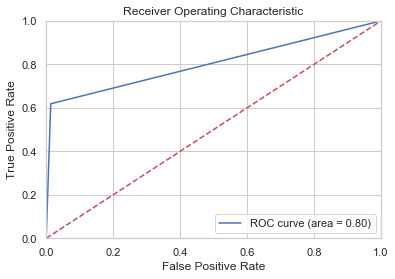

In [48]:
auc_score = metrics.roc_auc_score( Y_test, Pred_test )
round( float( auc_score ), 2 )
fpr, tpr, threshold = metrics.roc_curve(Y_test,Pred_test,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Confusion Matrix

Text(0.5, 12.5, 'Predicted label')

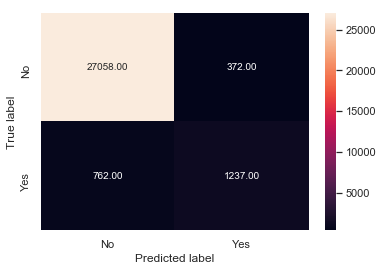

In [49]:
cm1 = metrics.confusion_matrix( Y_test,
                          Pred_test, [0,1] )
sns.heatmap(cm1, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)

### Model Prediction Probablity Distribution

In [31]:
resultDF = pd.DataFrame()
resultDF['prediction_Probablity'] = votingCPre.predict_proba(np.array(X_test))[:,1]
resultDF['ground_Truth']          = Y_test

In [32]:
resultDF['AMOUNT_USD'] = X_test.AMOUNT_USD

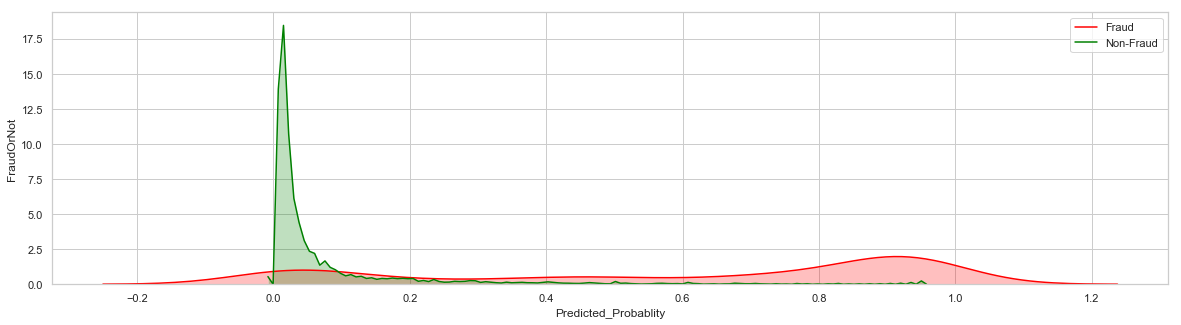

In [33]:
plt.figure(figsize=(20, 5))
g = sns.kdeplot(
    resultDF["prediction_Probablity"][(resultDF["ground_Truth"] == 1)],
    color="Red",
    shade=True)
g = sns.kdeplot(
    resultDF["prediction_Probablity"][(resultDF["ground_Truth"] == 0)],
    ax=g,
    color="Green",
    shade=True)
g.set_xlabel("Predicted_Probablity")
g.set_ylabel("FraudOrNot")
g = g.legend(["Fraud", "Non-Fraud"])

In [34]:
(resultDF[(resultDF.ground_Truth == 1)
             & (resultDF.prediction_Probablity > 0.25)].AMOUNT_USD.sum(
             ) / resultDF[(resultDF.ground_Truth == 1)].AMOUNT_USD.sum())*100

83.17017676613415

In [42]:
(resultDF[(resultDF.ground_Truth == 1)
             & (resultDF.prediction_Probablity > 0.65)].AMOUNT_USD.sum(
             ) / resultDF[(resultDF.ground_Truth == 1)].AMOUNT_USD.sum())*100

51.944007613994145

In [36]:
(resultDF[(resultDF.ground_Truth == 0)
             & (resultDF.prediction_Probablity > 0.65)].AMOUNT_USD.sum(
             ) / resultDF[(resultDF.ground_Truth == 1)].AMOUNT_USD.sum())*100

3.087411081231173

- As we can see that model prediction spread for fraudulent transaction is on the higher side
- we can also see that 83% of value is for transactions having predictions > 0.25
    - Therefore, we can keep a lower cap on 0.25 and all all the transactions to pass
    - We can ask for 2 set authentication about the user + ALERT_AGENT for which transactions having probability between 0.25 <= p <= 0.65  
    - We can block transactions and thereafter block user if probability > 0.65 by LOCK_USER and also ALERT_AGENT, As these transactions consists of 52% of Fraud Value and only 3% of clean amount is having such high score 

# Model Implementation 

### Idea Formation 

- I am planing to have a two phase detection process 
    1. Phase A := detection process will be based on user present in blacklisted fraud user's list and previously had blocked state and other basic check just to divert the clean traffic as we can see we have 99% of the clean and passing all these traffic through ML model may increase the latency thus, I will bounce most of the clean transactions through Phase A and only the suspicious transactions will be passed through ML model 
    2. Phase B := detection process will contain the ensemble model.

### PHASE A Detection Logic

In [72]:
downSampleDF.head()

,CURRENCY,AMOUNT,STATE_x,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID_x,AMOUNT_USD,ID_y,HAS_EMAIL,PHONE_COUNTRY,TERMS_VERSION,CREATED_DATE_y,STATE_y,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,CODE,NAME,CODE3,NUMCODE,PHONECODE,CCY,EXPONENT,IS_CRYPTO,MERCHANT_CATEGORY_,transaction_Year,transaction_Month,Fraud0rNot
0,GBP,1714,COMPLETED,2017-01-01 01:09:15.524,NaN,LUX,chip,fde8dd5a-5c34-4bc0-ac65-9014f936ec40,ATM,GAIA,3491e97e-7bca-46a2-a6e4-8f29cc174f3f,2160,fde8dd5a-5c34-4bc0-ac65-9014f936ec40,1,GB||JE||IM||GG,2018-05-25,2016-08-18 21:31:26.188,ACTIVE,GB,1994,PASSED,0,GB,United Kingdom,gBR,826.0,44.0,GBP,2,False,atm,2017,1,False
1,GBP,1988,COMPLETED,2017-01-01 01:47:23.611,NaN,LUX,chip,fde8dd5a-5c34-4bc0-ac65-9014f936ec40,CARD_PAYMENT,GAIA,e2c83066-eb7e-4fa8-88a1-acc8f1d6097b,2506,fde8dd5a-5c34-4bc0-ac65-9014f936ec40,1,GB||JE||IM||GG,2018-05-25,2016-08-18 21:31:26.188,ACTIVE,GB,1994,PASSED,0,GB,United Kingdom,gBR,826.0,44.0,GBP,2,False,card_payment,2017,1,False
2,EUR,485,COMPLETED,2017-01-01 02:15:39.103,supermarket,AUS,cont,ee69a4a4-1aae-4422-b02a-b65d74d21ef0,CARD_PAYMENT,GAIA,de502eec-f588-4c9f-b96a-27c8064550f2,539,ee69a4a4-1aae-4422-b02a-b65d74d21ef0,1,IE,2018-01-01,2016-06-30 21:31:35.723,ACTIVE,IE,1989,PASSED,0,IE,Ireland,iRL,372.0,353.0,EUR,2,False,supermarket,2017,1,False
3,EUR,1000,DECLINED,2017-01-01 02:18:35.980,NaN,EST,manu,6d4d3a1b-c9cf-48fd-92fd-8019ebdad02d,CARD_PAYMENT,GAIA,305e13d3-6808-462b-855f-d30dd8afe5c8,1112,6d4d3a1b-c9cf-48fd-92fd-8019ebdad02d,1,LT,2018-09-20,2016-09-21 08:07:08.868,ACTIVE,LT,1984,PASSED,0,LT,Lithuania,lTU,440.0,370.0,EUR,2,False,card_payment,2017,1,False
4,GBP,886,COMPLETED,2017-01-01 02:44:24.666,NaN,AUS,cont,6ec8a147-162a-461f-9a89-34cbb1275dff,CARD_PAYMENT,GAIA,a49b147e-bace-4813-ae11-d69b4ddf62a6,1116,6ec8a147-162a-461f-9a89-34cbb1275dff,1,GB||JE||IM||GG,1970-01-01,2016-10-26 18:59:59.948,ACTIVE,GB,1992,PASSED,0,GB,United Kingdom,gBR,826.0,44.0,GBP,2,False,card_payment,2017,1,False


In [75]:
pd.crosstab(downSampleDF.STATE_x,downSampleDF.Fraud0rNot)

Fraud0rNot,False,True
STATE_x,,
CANCELLED,94,20
COMPLETED,106385,10053
DECLINED,7439,2095
FAILED,3291,595
PENDING,620,6
REVERTED,7398,1141


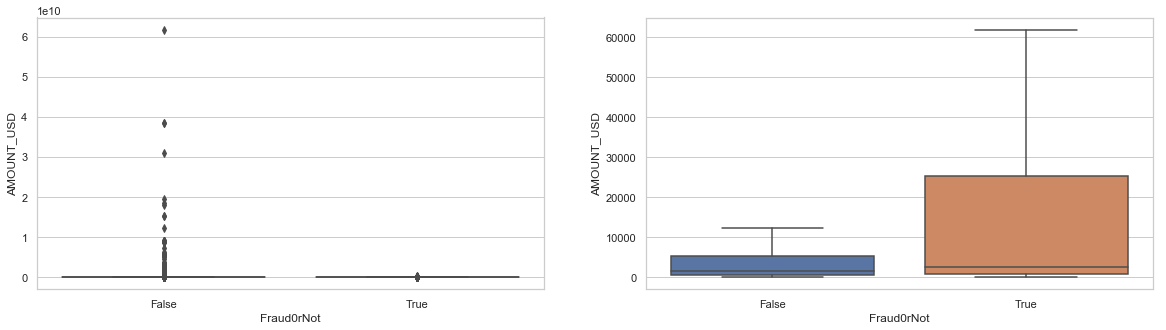

In [86]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))

sns.factorplot(y='AMOUNT_USD',
               x='Fraud0rNot',
               data=downSampleDF,
               kind='box',
               size=15,
               aspect=.4,
               showfliers=True,
               ax=axarr[0])
sns.factorplot(y='AMOUNT_USD',
               x='Fraud0rNot',
               data=downSampleDF,
               kind='box',
               size=15,
               aspect=.4,
               showfliers=False,
               ax=axarr[1])
plt.close(2)
plt.close(3)

In [91]:
downSampleDF[downSampleDF.Fraud0rNot==False].AMOUNT_USD.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

count    1.252270e+05
mean     6.164282e+06
std      3.072635e+08
min      0.000000e+00
10%      1.260000e+02
20%      3.510000e+02
30%      6.300000e+02
40%      1.023000e+03
50%      1.411000e+03
60%      2.269000e+03
70%      3.782000e+03
80%      6.481400e+03
90%      1.521480e+04
99%      1.199389e+05
max      6.167100e+10
Name: AMOUNT_USD, dtype: float64

In [92]:
downSampleDF[downSampleDF.Fraud0rNot==True].AMOUNT_USD.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

count    1.391000e+04
mean     6.246905e+04
std      1.995743e+06
min      0.000000e+00
10%      1.260000e+02
20%      3.780000e+02
30%      8.880000e+02
40%      1.260000e+03
50%      2.521000e+03
60%      5.042000e+03
70%      1.260600e+04
80%      3.359360e+04
90%      6.303400e+04
99%      5.673070e+05
max      1.936564e+08
Name: AMOUNT_USD, dtype: float64

In [93]:
(downSampleDF[(downSampleDF.Fraud0rNot == True)
             & (downSampleDF.AMOUNT_USD > 2.521000e+03)].AMOUNT_USD.sum(
             ) / downSampleDF[(downSampleDF.Fraud0rNot == True)].AMOUNT_USD.sum())*100

99.31771634434595

In [102]:
downSampleDF[downSampleDF.AMOUNT_USD >= 2.521000e+03 ].Fraud0rNot.value_counts()

False    47873
True      7062
Name: Fraud0rNot, dtype: int64

In [95]:
downSampleDF.Fraud0rNot.value_counts()

False    125227
True      13910
Name: Fraud0rNot, dtype: int64

In [96]:
pd.crosstab(downSampleDF.KYC,downSampleDF.Fraud0rNot)

Fraud0rNot,False,True
KYC,,
FAILED,213,367
NONE,480,0
PASSED,124518,11716
PENDING,16,1827


In [40]:
fraudster = downSampleDF[downSampleDF.Fraud0rNot==True].USER_ID.unique().tolist()

In [99]:
len(fraudster)

297

In [101]:
fraudster[0] in(fraudster)

True

- Based on the above rules can be derived as follows: 
    1. (str(current.USER_ID) in (fraudster)
    2. (current.AMOUNT_USD >= 2.521000e+03)
    3. (str(current.STATE_x) in ['DECLINED','FAILED','CANCELLED','PENDING','REVERTED'])
    4. (str(current.KYC) in ['FAILED','PENDING']

In [133]:
def phase_A_detection(current):
    Phase_A = np.where(
        (str(current.USER_ID) in (fraudster))
        | (current.AMOUNT_USD >= 2.521000e+03)
        | (str(current.STATE_x) in [
            'DECLINED', 'FAILED', 'CANCELLED', 'PENDING', 'REVERTED'
        ])
        | (str(current.KYC_) in ['FAILED', 'PENDING']), 1, 0)


    if Phase_A == 1:
        return 1
    else:
        return 0

### PHASE B Detection Logic

In [154]:
def phase_B_detection(prediction_Probablity):
    if prediction_Probablity <= 0.25:
        print("LET IT ROLL")
        return 0
    elif np.where((prediction_Probablity > 0.25) & (prediction_Probablity <= 0.65),1,0)==1:
        print("ALERT_AGENT")
        print("2 step authentication Initiated :")
        print("Tell me you mother's madian name & DOB")
        return 1
    elif  prediction_Probablity > 0.65:
        print("ALERT_AGENT + BLOCK_USER and BLOCK_Transaction")
        return 1

### Final Implementation

In [153]:
def detectionInitiated(current):
    X_T = current[current.columns.difference(['USER_ID','KYC_','STATE_x','Counter'])]
    if phase_A_detection(current)==1:
        prediction_Probablity = votingCPre.predict_proba(np.array(X_T))[:,1]
        return phase_B_detection(prediction_Probablity)
        
    else:
        return 0

In [53]:
testDF = pd.read_csv("C:/Users/suryadeept/Downloads/Revolut/Data/testDF.csv")

In [107]:
testDF.shape

(29429, 34)

In [155]:
start_time = time.time()
[detectionInitiated(X[X.Counter==i]) for i in range(X.shape[0])]
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
ALERT_AGENT
2 step authentication Initiated :
Tell me you mother's madian name & DOB
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET IT ROLL
LET 

'00:02:41'

### Result Analysis

In [193]:
X = pd.DataFrame()
X['ground_Truth'] = resultDF['ground_Truth']
X['USER_ID'] = testDF['USER_ID']
X['KYC_']    = testDF['KYC']
X['STATE_x'] = testDF['STATE_x']
X['prediction_Probablity'] = resultDF['prediction_Probablity']
X['AMOUNT_USD'] = resultDF['AMOUNT_USD']

In [195]:
X.head()

,ground_Truth,USER_ID,KYC_,STATE_x,prediction_Probablity,AMOUNT_USD
0,0,99afb4c9-7d89-47fe-bab0-5737e875a3aa,PASSED,COMPLETED,0.075088,2337
1,0,0dd5c1e2-56c9-438f-95bc-6935b859e34b,PASSED,COMPLETED,0.154508,3782
2,0,05bd5215-804c-4d4d-ab4b-a183a6bf119e,PASSED,COMPLETED,0.017550,1260
3,0,05bd5215-804c-4d4d-ab4b-a183a6bf119e,PASSED,COMPLETED,0.043833,334
4,0,c73660bc-c4f7-43c6-a189-b4ded615fce8,PASSED,COMPLETED,0.071497,101


In [201]:
predClass = pd.Series(
    np.where(
        ((X.USER_ID.isin(fraudster)) | (X.AMOUNT_USD >= 2.521000e+03) |
         (X.STATE_x.isin(
             ['DECLINED', 'FAILED', 'CANCELLED', 'PENDING', 'REVERTED'])) |
         (X.KYC_.isin(['FAILED', 'PENDING']))),
        np.where(X.prediction_Probablity <= 0.25, 0, 1), 0))

In [202]:
print(" Test Recall Score := ",metrics.recall_score(Y_test,predClass))
print(" Test Precision Score := ",metrics.precision_score(Y_test,predClass))
print(" Test AUC-ROC Score := ",metrics.roc_auc_score(Y_test,predClass))
print(" Test F1 Score := ",metrics.f1_score(Y_test,predClass))
print("Test Confusion Matrix:\n",metrics.confusion_matrix(Y_test,predClass))

 Test Recall Score :=  0.7408704352176088
 Test Precision Score :=  0.6582222222222223
 Test AUC-ROC Score :=  0.8564177185202152
 Test F1 Score :=  0.6971052012238174
Test Confusion Matrix:
 [[26661   769]
 [  518  1481]]


In [205]:
(X[(predClass == 1)&(X.ground_Truth == 1)]['AMOUNT_USD'].sum()/X[X.ground_Truth == 1]['AMOUNT_USD'].sum())*100

83.17017676613415

Text(0.5, 0, 'False Positive Rate')

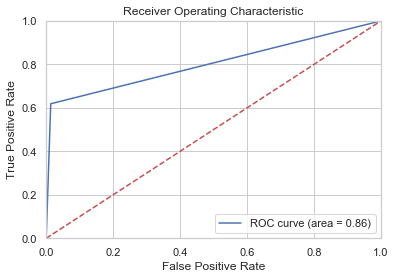

In [206]:
auc_score = metrics.roc_auc_score( Y_test, predClass )
round( float( auc_score ), 2 )
fpr, tpr, threshold = metrics.roc_curve(Y_test,Pred_test,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 12.5, 'Predicted label')

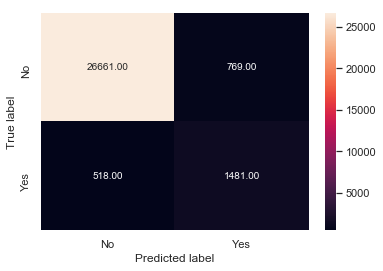

In [207]:
cm1 = metrics.confusion_matrix( Y_test,
                          predClass, [0,1] )
sns.heatmap(cm1, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)

- As we can see by deploying phase-A and phase-B detection scheme Model get a performance boost considerably. Let's look at the results 
    1. Recall    :=  74% of the total fraud cases are caught which consist of 83.2% of the value associated to it.
    2. Precision :=  66% of the frauds are correctly caught, we can see the precision goes down and this is what PR trade-off is all about 
    3. ROC-AUC   :=  86% of the area is covered 
    4. F1-Score  :=  70% 

# ============== END =============== #